
## Abstract
Fuente del dataset:
https://www.kaggle.com/jessemostipak/hotel-booking-demand

Son dos datasets con reservas de hotel y su estadío final. Un hotel es de tipo resort y el otro es un hotel de ciudad. Ambos datasets comparten la misma estructura, con 31 variables que describen 40,060 observaciones del hotel 1 y 79,330 observaciones del hotel 2. Cada observación representa una reserva de hotel. Comprenden reservas desde el 1 de Julio de 2015 al 31 de Agosto de 2017, incluyendo reservas que se efectivizaron y aquellas que fueron canceladas.

Nos planteamos la posibilidad de anticipar futuras cancelaciones. Para el negocio puede ayudar sobrevendiendo cuartos o asegurando una mejor administración de recursos de acuerdo a la cantidad "real" de huespedes esperados.



### Técnicas a utilizar


*   Análisis Exploratotio del Dataset. (EDA)
*   Eliminación de Outliers.
*   Creación de features, importando datasets externos.
*   Categorización de variables cuantitativas.
*   Data Wrangling y Dummies.
*   Reducción de Dimensionalidad (PCA).
*   Train-Test Split.
*   Normalización (Standarization).
*   Cross Validation.
*   Obtener los mejores C, K y N.
*   Uso de Filter y Wrapper.
*   Testeo de modelos con Oversampling, Undersampling y Balanceados.
*   Evaluación de modelos utilizando diferentes métricas.
*   Sampleo y testeo del mejor modelo.



## Importación de librerias y dataset


In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import unidecode

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score, roc_curve, auc, roc_auc_score

%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.2f' % x) #Para cambiar el formato de los números
pd.set_option('display.max_columns', None)

import sys
!{sys.executable} -m pip install sklearn.utils

#conda install -c conda-forge imblearn
import sys
!{sys.executable} -m pip install imblearn

import sys
!{sys.executable} -m pip install sklearn


In [0]:
# Leemos el Archivo

df = pd.read_csv('hotel_bookings.csv')
df_original = df
df = df.replace(' ', np.nan)
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,nan,nan,0,Transient,0.00,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,nan,nan,0,Transient,0.00,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,nan,nan,0,Transient,75.00,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.00,nan,0,Transient,75.00,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.00,nan,0,Transient,98.00,0,1,Check-Out,2015-07-03


In [0]:
# # Corremos pandas profiling para el dataset
# # para instalarlo
# #!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
# conda install -c conda-forge pandas-profiling
# import sys
# !{sys.executable} -m pip install pandas-profiling
# from pandas_profiling import ProfileReport
# # profile = ProfileReport(df, 
# #                         title='Pandas Profiling Report', 
# #                         html={'style':{'full_width':True}}, progress_bar=False)

# # profile.to_file(output_file="Reporte Hoteles.html")

In [0]:
# Se importa un DF con los códigos y nombres de paises para facilitar la lectura
ctyname = pd.read_csv('CountryNames.csv')
df = df.merge(ctyname,left_on='country', right_on='Alpha-3 code',how="left")
df = df.drop(['French short name', 'Alpha-2 code','Numeric','country'], axis=1)
df.rename(columns={'English short name':'country','Alpha-3 code':'country_code'}, inplace=True)

In [0]:
# Super hiperparametros:

testsize = 0.25


## EDA y Limpieza

In [0]:
# Se crea una función que cambia los features con strings a respectivos valores numericos:
def cambio_string_to_number(df, columntochange):
    yourdic ={}
    yourdic = dict(zip(df[columntochange].unique(), range(len(df[columntochange].unique()))))
    df[columntochange]=df[columntochange].map(yourdic)
    return df
    

In [0]:
# Aplico una funcion para quitar todos los acentos y poner todos los textos en minúsculas
df = df.applymap(lambda x: unidecode.unidecode(x).lower() if isinstance(x,str) else x)
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,country,country_code
0,resort hotel,0,342,2015,july,27,1,0,0,2,0.00,0,bb,direct,direct,0,0,0,c,c,3,no deposit,nan,nan,0,transient,0.00,0,0,check-out,2015-07-01,portugal,prt
1,resort hotel,0,737,2015,july,27,1,0,0,2,0.00,0,bb,direct,direct,0,0,0,c,c,4,no deposit,nan,nan,0,transient,0.00,0,0,check-out,2015-07-01,portugal,prt
2,resort hotel,0,7,2015,july,27,1,0,1,1,0.00,0,bb,direct,direct,0,0,0,a,c,0,no deposit,nan,nan,0,transient,75.00,0,0,check-out,2015-07-02,united kingdom of great britain and northern i...,gbr
3,resort hotel,0,13,2015,july,27,1,0,1,1,0.00,0,bb,corporate,corporate,0,0,0,a,a,0,no deposit,304.00,nan,0,transient,75.00,0,0,check-out,2015-07-02,united kingdom of great britain and northern i...,gbr
4,resort hotel,0,14,2015,july,27,1,0,2,2,0.00,0,bb,online ta,ta/to,0,0,0,a,a,0,no deposit,240.00,nan,0,transient,98.00,0,1,check-out,2015-07-03,united kingdom of great britain and northern i...,gbr


In [0]:
# Se elimina las columnas que se generar posterior a saber si la reserva fue cancelada o no
try:
    #df = df.drop(['reservation_status','reservation_status_date','arrival_date_year'], axis=1)
    df = df.drop(['reservation_status','reservation_status_date'], axis=1)
except:
    pass

In [0]:
# Se renombarn las columnas para que sean mas fáciles de entender:

df.rename(columns={'lead_time':'lead_time_days',
                   'stays_in_weekend_nights':'nights_stay_weekend',
                   'stays_in_week_nights':'nights_stay_week',
                   'adr':'average_d_rate',
                   'arrival_date_year':'year_of_arrival',
                   'arrival_date_month':'month_of_arrival',
                   'arrival_date_month_number':'number_month_of_arrival',
                   'arrival_date_week_number':'week_in_year_of_arrival' }, inplace = True)

In [0]:
df.head()

,hotel,is_canceled,lead_time_days,year_of_arrival,month_of_arrival,week_in_year_of_arrival,arrival_date_day_of_month,nights_stay_weekend,nights_stay_week,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,average_d_rate,required_car_parking_spaces,total_of_special_requests,country,country_code
0,resort hotel,0,342,2015,july,27,1,0,0,2,0.00,0,bb,direct,direct,0,0,0,c,c,3,no deposit,nan,nan,0,transient,0.00,0,0,portugal,prt
1,resort hotel,0,737,2015,july,27,1,0,0,2,0.00,0,bb,direct,direct,0,0,0,c,c,4,no deposit,nan,nan,0,transient,0.00,0,0,portugal,prt
2,resort hotel,0,7,2015,july,27,1,0,1,1,0.00,0,bb,direct,direct,0,0,0,a,c,0,no deposit,nan,nan,0,transient,75.00,0,0,united kingdom of great britain and northern i...,gbr
3,resort hotel,0,13,2015,july,27,1,0,1,1,0.00,0,bb,corporate,corporate,0,0,0,a,a,0,no deposit,304.00,nan,0,transient,75.00,0,0,united kingdom of great britain and northern i...,gbr
4,resort hotel,0,14,2015,july,27,1,0,2,2,0.00,0,bb,online ta,ta/to,0,0,0,a,a,0,no deposit,240.00,nan,0,transient,98.00,0,1,united kingdom of great britain and northern i...,gbr


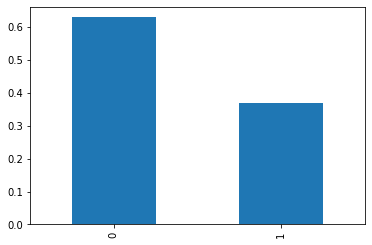

In [0]:
is_canceled_chart = df['is_canceled'].value_counts(normalize = True)
is_canceled_line = is_canceled_chart.loc[1]*100
is_canceled_chart.plot(kind="bar")

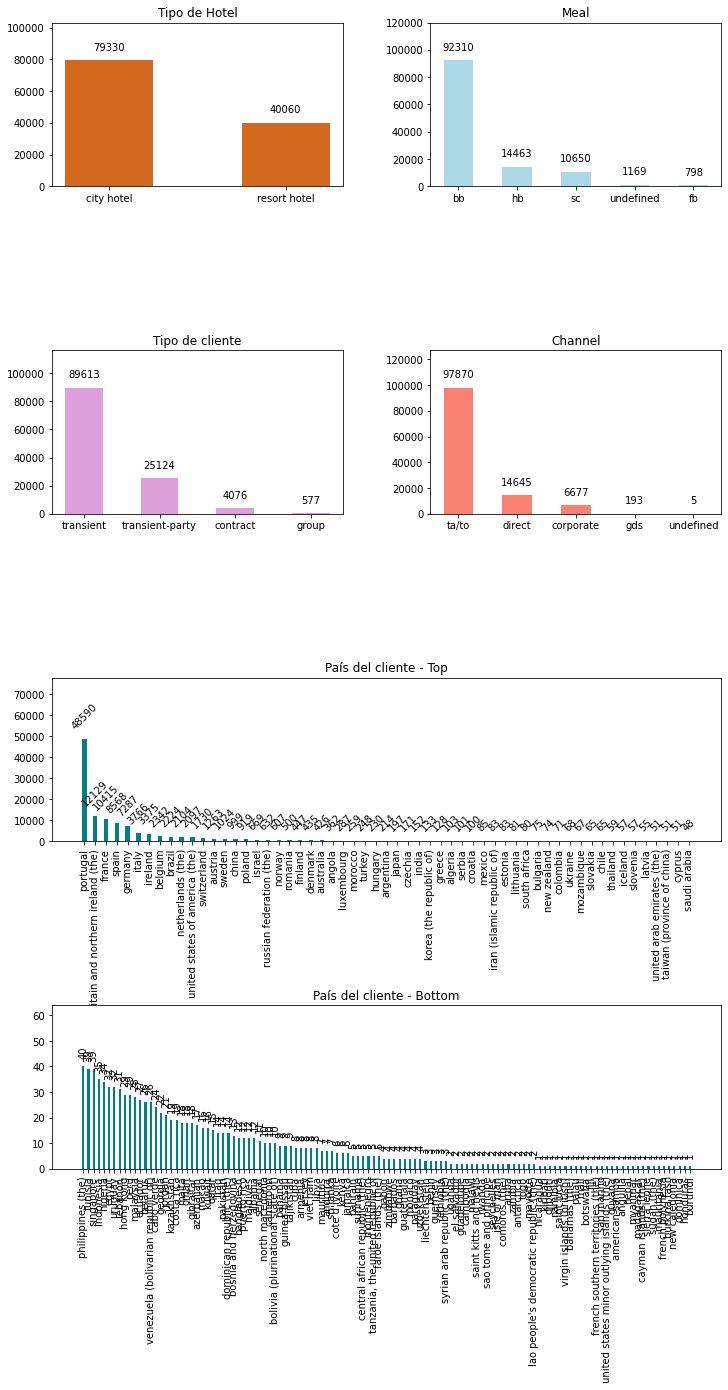

In [0]:
#Ver posibles agrupaciones:
hotel_chart = df['hotel'].value_counts()
customer_chart = df['customer_type'].value_counts()
meal_chart = df['meal'].value_counts()
channel_chart = df['distribution_channel'].value_counts()
country_chart = df['country'].value_counts()
ctrytop_chart = country_chart[country_chart > 40]
ctrybottom_chart = country_chart[country_chart <= 40]

fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(wspace = 0.3,
                      hspace = 1,
                      left = 0.125,
                      right = 0.9,
                      top = 2,
                      bottom = 0.01)

def etiquetas(indice,dato, rotate):                    
    for x,y in zip(indice, dato):
        label = "{:.0f}".format(y)
        plt.annotate(label, 
                 (x,y),
                 rotation = rotate,  
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center') 
    
plt.subplot(421)
plt.bar(hotel_chart.index, hotel_chart, width=0.5,
        color='chocolate')
etiquetas(hotel_chart.index, hotel_chart,0)
plt.title('Tipo de Hotel')
plt.axis(ymin= 0, ymax=np.max(hotel_chart)*1.30)

plt.subplot(422)
plt.bar(meal_chart.index, meal_chart, width=0.5,
        color='lightblue')
etiquetas(meal_chart.index, meal_chart,0)
plt.title('Meal')
plt.axis(ymin= 0, ymax=np.max(meal_chart)*1.30)

plt.subplot(423)
plt.bar(customer_chart.index, customer_chart, width=0.5,
        color='plum')
plt.title('Tipo de cliente')
etiquetas(customer_chart.index, customer_chart,0)
plt.axis(ymin= 0, ymax=np.max(customer_chart)*1.30)

plt.subplot(424)
plt.bar(channel_chart.index, channel_chart, width=0.5,
        color='salmon')
etiquetas(channel_chart.index, channel_chart,0)
plt.title('Channel')
plt.axis(ymin= 0, ymax=np.max(channel_chart)*1.30)

fig.add_subplot(4,1,3)
plt.bar(ctrytop_chart.index, ctrytop_chart, width=0.4,
        color='teal')
etiquetas(ctrytop_chart.index, ctrytop_chart,45)
plt.xticks(rotation=90)
plt.title('País del cliente - Top')
plt.axis(ymin= 0, ymax=np.max(ctrytop_chart)*1.60)

fig.add_subplot(4,1,4)
plt.bar(ctrybottom_chart.index, ctrybottom_chart, width=0.4,
        color='teal')
etiquetas(ctrybottom_chart.index, ctrybottom_chart,90)
plt.xticks(rotation=90)
plt.title('País del cliente - Bottom')
plt.axis(ymin= 0, ymax=np.max(ctrybottom_chart)*1.60);

In [0]:
# Se puede ver que hay valores extremos superiores, pero los mínimos son correctos ya que según booking.com
# En portugal el precio mínimo de una noche es de 15 euros
df['average_d_rate'].describe()
df_sin_outliers = df.loc[df['average_d_rate']>15]
df_sin_outliers = df[df['average_d_rate']<1000]

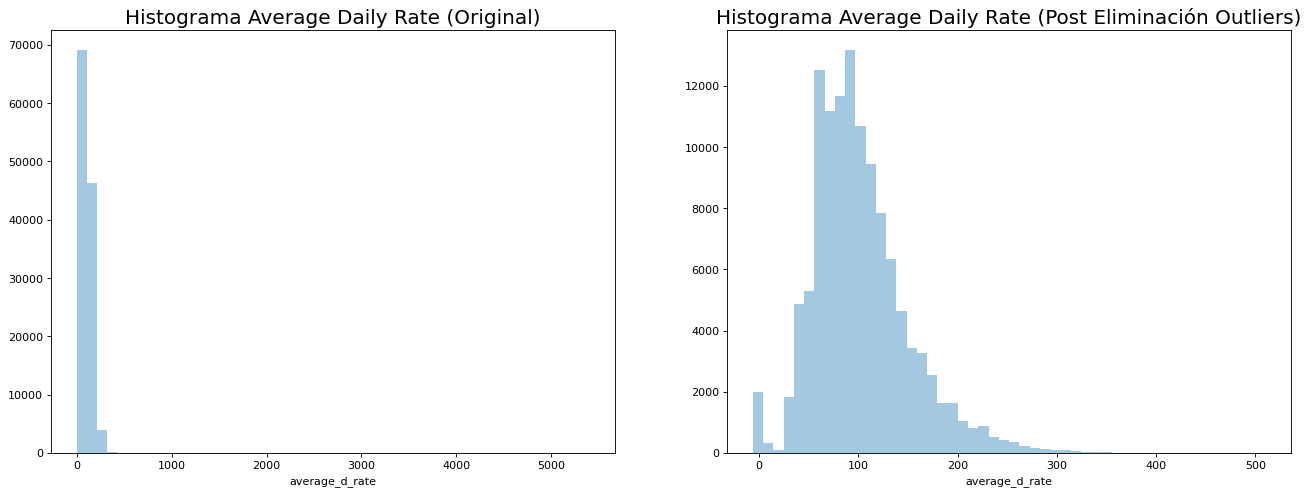

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.distplot(df['average_d_rate'],kde = False,ax=axes[0])
sns.distplot(df_sin_outliers['average_d_rate'],kde = False)

axes[0].set_title('Histograma Average Daily Rate (Original)', fontsize=18); 
axes[1].set_title('Histograma Average Daily Rate (Post Eliminación Outliers)', fontsize=18)

plt.show()

In [0]:
df = df[df['average_d_rate']<1000]
df = df[df['average_d_rate']>15]

### Correlacion
Finalmente vemos como queda la correlación de todas las features existentes (post eliminación de outliers)

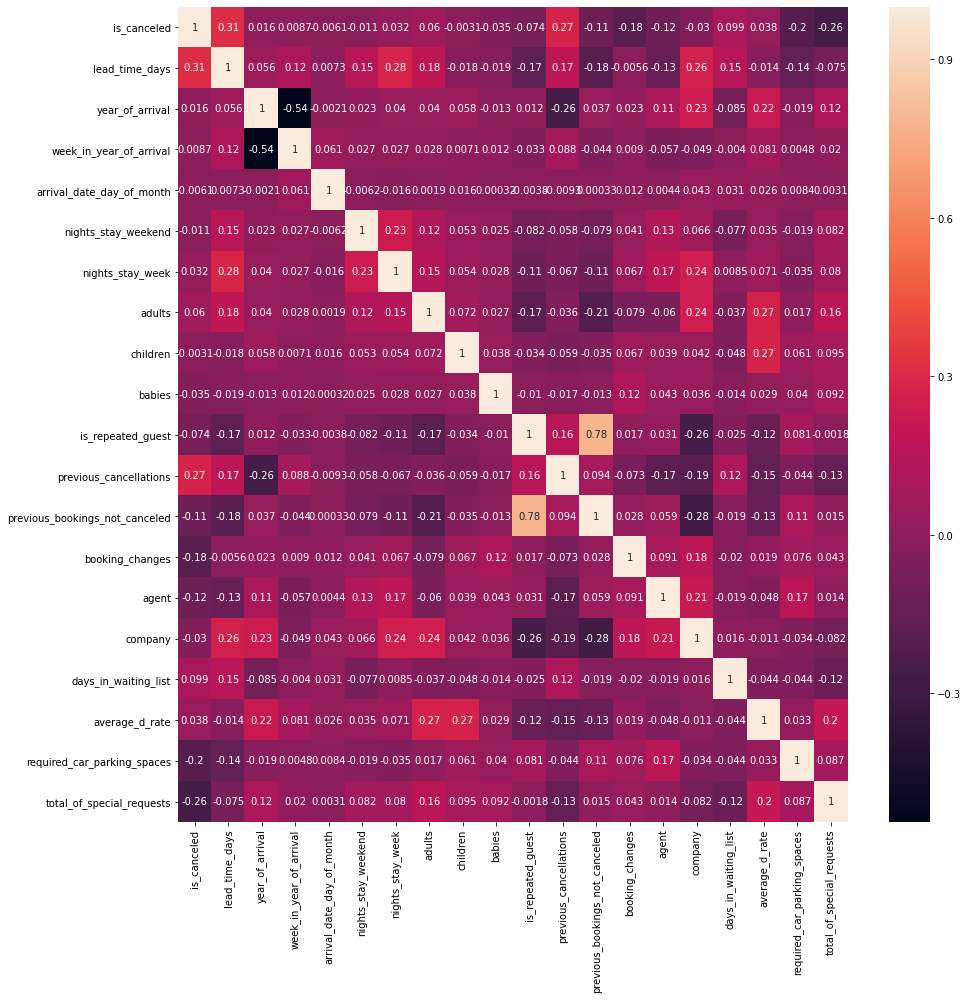

In [0]:
#sns.pairplot(df);
f,ax=plt.subplots(figsize=(15,15))
sns.heatmap(df.corr(method = 'spearman').iloc[0:len(df),0:len(df)], annot=True)
sns.color_palette("RdBu_r", 7);


## Generación de Nuevas Features

### Feature de país
Como se vio en el EDA, existen un monton de países diferentes. Crear dummies para todos aumentaría la dimensinalidad del dataset enormemente. Además, podría pasar que una nueva reserva provenga de un país que no está en el dataset de entreamiento.
Se proponen dos feautures para reemplazar el país:
* Crear una feature del continente
* Crear una feature del PBI per cápita del pais en cuestion. Esto transformaría el país es una feature numérica que se podría disponer en una sola columna. Sin embargo para facilitar el ingreso de nuevas reservas, se categorizará al PBI per cápita en categorías.

In [0]:
# Se importa un dataset de paises, años y PBI per capita
dfgdp = pd.read_csv('gdp-per-capita-worldbank.csv')
dfgdp.rename(columns={ dfgdp.columns[3]: "PBI" }, inplace = True)
dfgdp= dfgdp.dropna()

# Se aplica una funcion para quitar todos los acentos y poner todos los textos en minúsculas
dfgdp = dfgdp.applymap(lambda x: unidecode.unidecode(x).lower() if isinstance(x,str) else x)
dfgdp

,Entity,Code,Year,PBI
0,afghanistan,afg,2002,1063.64
1,afghanistan,afg,2003,1099.19
2,afghanistan,afg,2004,1062.25
3,afghanistan,afg,2005,1136.12
4,afghanistan,afg,2006,1161.12
...,...,...,...,...
6402,zimbabwe,zwe,2013,1929.77
6403,zimbabwe,zwe,2014,1925.14
6404,zimbabwe,zwe,2015,1912.28
6405,zimbabwe,zwe,2016,1879.63


In [0]:
# Se tomará el dato más reciente de PBI per cápita para cada país

dfgdp2use = pd.DataFrame(columns=['Code', 'PBILast'])
for pais in dfgdp.Code.unique():
    a = dfgdp.loc[dfgdp['Code']==pais].Year.max()
    PBI = dfgdp.loc[(dfgdp['Code']==pais) & (dfgdp['Year']==a), 'PBI'].values
    PBI.astype(str).astype(float)
    dfgdp2use = dfgdp2use.append({'Code': pais, 'PBILast': PBI}, ignore_index=True)

    
#dfgdp2use['PBI'] = int(dfgdp2use['PBI'])  
dfgdp2use['PBILast'].astype(str)
dfgdp2use = dfgdp2use.replace('[', '')
dfgdp2use = dfgdp2use.replace(']', '')
dfgdp2use['PBILast'] = dfgdp2use['PBILast'].astype(float)
dfgdp2use
    

/Users/martinmarcos/opt/anaconda3/lib/python3.7/site-packages/pandas/core/missing.py:47: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


,Code,PBILast
0,afg,1803.99
1,alb,11803.43
2,dza,13913.84
3,ago,5819.49
4,atg,21490.94
...,...,...
191,vnm,6171.88
192,owid_wrl,15469.21
193,yem,1479.15
194,zmb,3689.25


In [0]:
# Se joinea el dataset se PBI con el df y se elimina la columna de país
df = df.merge(dfgdp2use,left_on='country_code', right_on='Code',how="left")
try:
    df = df.drop(['Code'], axis=1)
except:
    pass

df.head()

,hotel,is_canceled,lead_time_days,year_of_arrival,month_of_arrival,week_in_year_of_arrival,arrival_date_day_of_month,nights_stay_weekend,nights_stay_week,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,average_d_rate,required_car_parking_spaces,total_of_special_requests,country,country_code,PBILast
0,resort hotel,0,7,2015,july,27,1,0,1,1,0.00,0,bb,direct,direct,0,0,0,a,c,0,no deposit,nan,nan,0,transient,75.00,0,0,united kingdom of great britain and northern i...,gbr,39753.24
1,resort hotel,0,13,2015,july,27,1,0,1,1,0.00,0,bb,corporate,corporate,0,0,0,a,a,0,no deposit,304.00,nan,0,transient,75.00,0,0,united kingdom of great britain and northern i...,gbr,39753.24
2,resort hotel,0,14,2015,july,27,1,0,2,2,0.00,0,bb,online ta,ta/to,0,0,0,a,a,0,no deposit,240.00,nan,0,transient,98.00,0,1,united kingdom of great britain and northern i...,gbr,39753.24
3,resort hotel,0,14,2015,july,27,1,0,2,2,0.00,0,bb,online ta,ta/to,0,0,0,a,a,0,no deposit,240.00,nan,0,transient,98.00,0,1,united kingdom of great britain and northern i...,gbr,39753.24
4,resort hotel,0,0,2015,july,27,1,0,2,2,0.00,0,bb,direct,direct,0,0,0,c,c,0,no deposit,nan,nan,0,transient,107.00,0,0,portugal,prt,27936.90


In [0]:
# Se crean categorias según el nivel del PBI per capita
df['PBICat'] = pd.cut(df['PBILast'], 5, labels=["1", "2", "3", '4', '5']).values

In [0]:
#  Check continents

dfcontinent = pd.read_csv('country-and-continent-codes-list-csv_csv.csv')
# Se aplica una funcion para quitar todos los acentos y poner todos los textos en minúsculas
dfcontinent = dfcontinent.applymap(lambda x: unidecode.unidecode(x).lower() if isinstance(x,str) else x)
df = df.merge(dfcontinent[['Three_Letter_Country_Code','Continent_Name']],left_on='country_code', right_on='Three_Letter_Country_Code',how="left")
df.head()


,hotel,is_canceled,lead_time_days,year_of_arrival,month_of_arrival,week_in_year_of_arrival,arrival_date_day_of_month,nights_stay_weekend,nights_stay_week,adults,children,babies,meal,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,average_d_rate,required_car_parking_spaces,total_of_special_requests,country,country_code,PBILast,PBICat,Three_Letter_Country_Code,Continent_Name
0,resort hotel,0,7,2015,july,27,1,0,1,1,0.00,0,bb,direct,direct,0,0,0,a,c,0,no deposit,nan,nan,0,transient,75.00,0,0,united kingdom of great britain and northern i...,gbr,39753.24,2,gbr,europe
1,resort hotel,0,13,2015,july,27,1,0,1,1,0.00,0,bb,corporate,corporate,0,0,0,a,a,0,no deposit,304.00,nan,0,transient,75.00,0,0,united kingdom of great britain and northern i...,gbr,39753.24,2,gbr,europe
2,resort hotel,0,14,2015,july,27,1,0,2,2,0.00,0,bb,online ta,ta/to,0,0,0,a,a,0,no deposit,240.00,nan,0,transient,98.00,0,1,united kingdom of great britain and northern i...,gbr,39753.24,2,gbr,europe
3,resort hotel,0,14,2015,july,27,1,0,2,2,0.00,0,bb,online ta,ta/to,0,0,0,a,a,0,no deposit,240.00,nan,0,transient,98.00,0,1,united kingdom of great britain and northern i...,gbr,39753.24,2,gbr,europe
4,resort hotel,0,0,2015,july,27,1,0,2,2,0.00,0,bb,direct,direct,0,0,0,c,c,0,no deposit,nan,nan,0,transient,107.00,0,0,portugal,prt,27936.90,2,prt,europe


In [0]:
try:
    df = df.drop(['Three_Letter_Country_Code'], axis=1)
except:
    pass

In [0]:
#Armamos una función para graficar los % vs el % de cancelación global.
from math import isnan

def etiquetas_v2(indice,dato, rotate):                    
    for x,y in zip(indice, dato/100):
        label = "{:.0%}".format(y)
        plt.annotate(label, 
                 (x,((y*100)/2)),
                 rotation = rotate,  
                 textcoords="offset points", 
                 xytext=(0,5), 
                 ha='center') 

def plotVScanceled (groupbytable, **kwargs):
    ejex = list(groupbytable.columns)
    ejey = groupbytable.loc[1]
    ejey = [0 if isnan(x) else x for x in ejey]
    
    fig, ax =  plt.subplots(figsize=(len(ejex)+2,4))
    #plt.figure(figsize=(len(ejex)+2,4))
    width = .35 # width of a bar
    fig.subplots_adjust(wspace = 0.3,hspace = 1,left = 0.125,right = 0.9,top = 0.8,bottom = 0.01)
    plt.title(groupbytable.columns.name)
    ax.bar(ejex, ejey, width, color=sns.color_palette("Set2",len(ejex)), label='_nolegend_')
    ax.set_xticks(ejex)
    etiquetas_v2(ejex, groupbytable.loc[1],0)
    ax.axis(ymin= 0, ymax=100*1.10)
    ax.axhline(y=is_canceled_line, color='r', label="{:.0%}".format(is_canceled_line/100))
    ax.legend(title="% de Cancelación",handlelength= 2, shadow=True)
    return plt

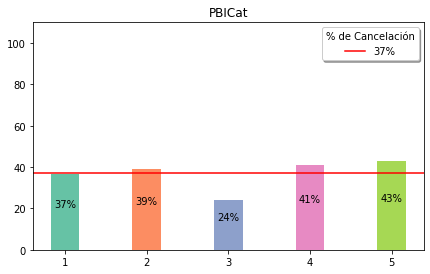

In [0]:
 plotVScanceled (df_cancelby_PBICat);

En este caso se puede ver que la tasa de cancelación varía entre categorías, por lo que es una feature a mantener.

In [0]:


df_cancelby_Continent = df.groupby(["is_canceled","PBICat"])['PBICat'].count().unstack().transform(lambda x: (x * 100) / x.sum())

display(df_cancelby_PBICat,
        is_canceled_chart)



In [0]:
# Continentes

df_cancelby_continent = df.groupby(["is_canceled","Continent_Name"])['Continent_Name'].count().unstack().transform(lambda x: (x * 100) / x.sum())

display(df_cancelby_continent,
        is_canceled_chart)

Continent_Name,africa,antarctica,asia,europe,north america,oceania,south america
is_canceled,,,,,,,
0,56.44,100.00,73.55,61.88,76.75,80.98,64.45
1,43.56,nan,26.45,38.12,23.25,19.02,35.55


0   0.63
1   0.37
Name: is_canceled, dtype: float64

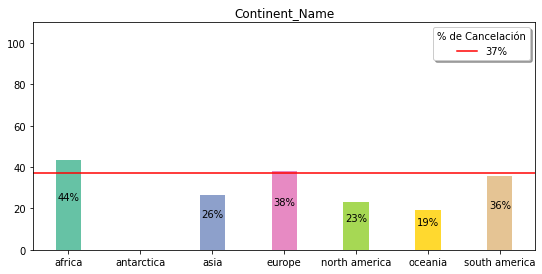

In [0]:
 plotVScanceled (df_cancelby_continent);

### Feature 'deposit_type'

In [0]:
df_cancelby_deposit_type = df.groupby(["is_canceled","deposit_type"])['deposit_type'].count().unstack().transform(lambda x: (x * 100) / x.sum())
display(df_cancelby_deposit_type, is_canceled_chart)

deposit_type,no deposit,non refund,refundable
is_canceled,,,
0,71.81,0.67,79.14
1,28.19,99.33,20.86


0   0.63
1   0.37
Name: is_canceled, dtype: float64

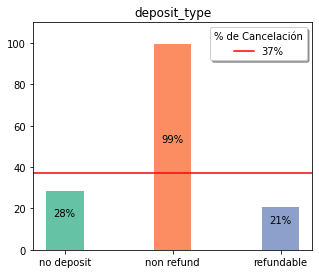

In [0]:
 plotVScanceled (df_cancelby_deposit_type);

En este caso se puede ver que la tasa de cancelación varía entre categorías, por lo que es una feature a mantener.

### Feature 'customer_type'


In [0]:
df_cancelby_customer_type = df.groupby(["is_canceled","customer_type"])['customer_type'].count().unstack().transform(lambda x: (x * 100) / x.sum())
display(df_cancelby_customer_type, is_canceled_chart)

customer_type,contract,group,transient,transient-party
is_canceled,,,,
0,69.26,92.88,59.62,75.33
1,30.74,7.12,40.38,24.67


0   0.63
1   0.37
Name: is_canceled, dtype: float64

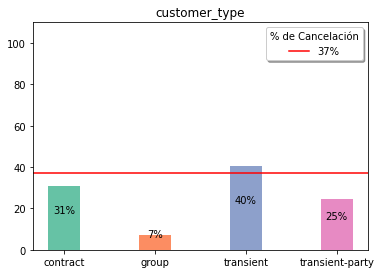

In [0]:
plotVScanceled (df_cancelby_customer_type);

En este caso se puede ver que la tasa de cancelación varía entre categorías, por lo que es una feature a mantener.

### Feature 'meal'

In [0]:
df_cancelby_meal = df.groupby(["is_canceled","meal"])['meal'].count().unstack().transform(lambda x: (x * 100) / x.sum())
display(df_cancelby_meal, is_canceled_chart)

meal,bb,fb,hb,sc,undefined
is_canceled,,,,,
0,63.15,39.47,65.71,62.45,75.66
1,36.85,60.53,34.29,37.55,24.34


0   0.63
1   0.37
Name: is_canceled, dtype: float64

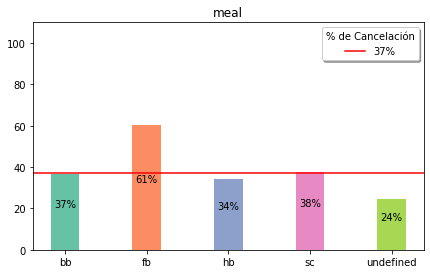

In [0]:
plotVScanceled (df_cancelby_meal);

En este caso se puede ver que la tasa de cancelación varía entre categorías, por lo que es una feature a mantener.

### Feature 'week_in_year_of_arrival'

In [0]:
df_cancelby_week_in_year_of_arrival = df.groupby(["is_canceled","week_in_year_of_arrival"])['week_in_year_of_arrival'].count().unstack().transform(lambda x: (x * 100) / x.sum())
display(df_cancelby_week_in_year_of_arrival, is_canceled_chart)

week_in_year_of_arrival,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,65.71,67.02,75.46,66.92,68.97,75.11,67.61,65.08,66.14,65.97,70.10,69.68,64.32,63.67,61.90,58.88,57.39,55.06,64.16,56.30,64.55,60.91,59.68,60.50,54.05,64.68,63.13,63.93,63.60,59.92,64.65,62.76,58.24,66.02,64.47,62.27,62.03,61.94,63.71,59.39,59.78,59.58,62.84,68.43,61.04,63.31,77.64,74.98,62.84,59.12,74.35,69.68,64.30
1,34.29,32.98,24.54,33.08,31.03,24.89,32.39,34.92,33.86,34.03,29.90,30.32,35.68,36.33,38.10,41.12,42.61,44.94,35.84,43.70,35.45,39.09,40.32,39.50,45.95,35.32,36.87,36.07,36.40,40.08,35.35,37.24,41.76,33.98,35.53,37.73,37.97,38.06,36.29,40.61,40.22,40.42,37.16,31.57,38.96,36.69,22.36,25.02,37.16,40.88,25.65,30.32,35.70


0   0.63
1   0.37
Name: is_canceled, dtype: float64

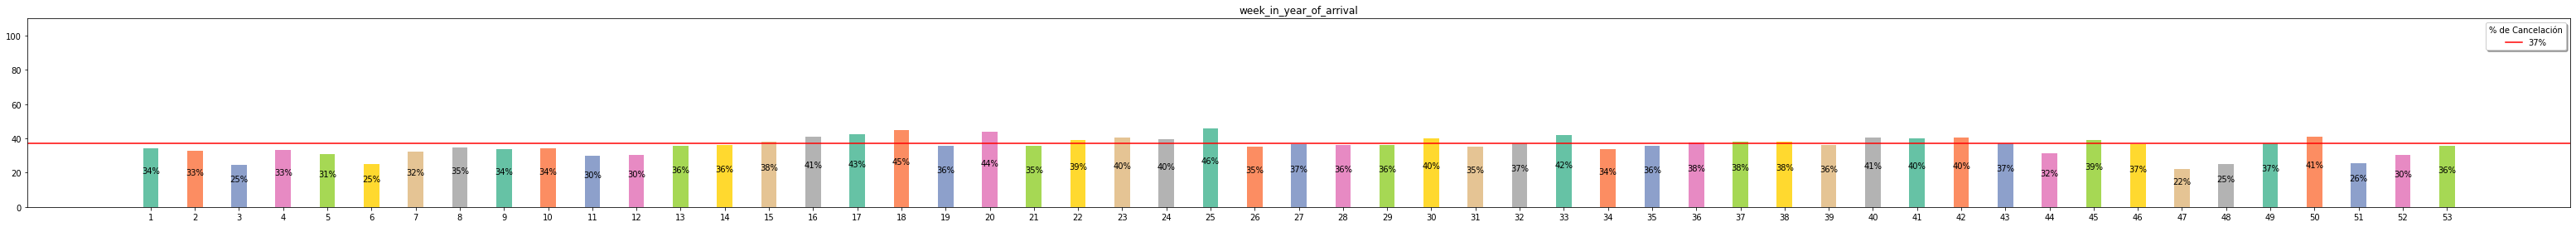

In [0]:
plotVScanceled (df_cancelby_week_in_year_of_arrival);

En este caso se puede ver que la tasa de cancelación varía entre semanas. Es decir que sería importante (En la medida que las dimensiones no aumenten demasiado) mantener la feature de semana.

### Feature en función de la cantidad de noches

En esta sección se analiza la tasa de cancelación en función de la cantidad de noches. Ya sea durante el fin de semana, durante la semana, o total.

In [0]:
df_cancelby_nights_stay_weekend = df.groupby(["is_canceled","nights_stay_weekend"])['nights_stay_weekend'].count().unstack().transform(lambda x: (x * 100) / x.sum())
df_cancelby_nights_stay_week = df.groupby(["is_canceled","nights_stay_week"])['nights_stay_week'].count().unstack().transform(lambda x: (x * 100) / x.sum())

df['total_nights'] = df["nights_stay_week"]+df["nights_stay_weekend"]
df_cancelby_nights_total_nights = df.groupby(["is_canceled","total_nights"])['total_nights'].count().unstack().transform(lambda x: (x * 100) / x.sum())

df['total_nights_cat'] = pd.cut(df['total_nights'], bins =[0, 1, 14, 5500] , labels=["1", "2", "3"]).values
df_cancelby_total_nights_cat = df.groupby(["is_canceled","total_nights_cat"])['total_nights_cat'].count().unstack().transform(lambda x: (x * 100) / x.sum())

display(df_cancelby_nights_stay_weekend, 
        df_cancelby_nights_stay_week, 
        df_cancelby_nights_total_nights, 
        df_cancelby_total_nights_cat)

nights_stay_weekend,0,1,2,3,4,5,6,7,8,9,10,12,13,16,18,19
is_canceled,,,,,,,,,,,,,,,,
0,62.61,64.59,63.19,66.67,67.12,43.42,53.37,26.32,38.81,22.22,71.43,75.00,100.00,50.00,100.00,100.00
1,37.39,35.41,36.81,33.33,32.88,56.58,46.63,73.68,61.19,77.78,28.57,25.00,nan,50.00,nan,nan


nights_stay_week,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24,25,30,32,40,42,50
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,73.46,68.02,56.90,62.19,63.99,65.25,61.49,70.25,62.80,57.79,71.95,35.09,54.90,63.33,11.43,49.45,38.89,71.43,16.67,60.27,55.56,12.50,nan,nan,100.00,75.00,100.00,50.00,100.00,100.00
1,26.54,31.98,43.10,37.81,36.01,34.75,38.51,29.75,37.20,42.21,28.05,64.91,45.10,36.67,88.57,50.55,61.11,28.57,83.33,39.73,44.44,87.50,100.00,100.00,nan,25.00,nan,50.00,nan,nan


total_nights,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,33,34,35,42,45,56,60,69
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,75.38,56.57,58.51,64.99,65.39,60.78,65.83,62.18,62.72,70.49,69.01,47.45,63.87,72.56,48.65,55.10,77.27,17.14,27.27,7.14,50.65,75.00,45.45,16.67,65.67,nan,nan,62.50,6.67,7.69,nan,100.00,100.00,75.00,100.00,50.00,100.00,100.00
1,24.62,43.43,41.49,35.01,34.61,39.22,34.17,37.82,37.28,29.51,30.99,52.55,36.13,27.44,51.35,44.90,22.73,82.86,72.73,92.86,49.35,25.00,54.55,83.33,34.33,100.00,100.00,37.50,93.33,92.31,100.00,nan,nan,25.00,nan,50.00,nan,nan


total_nights_cat,1,2,3
is_canceled,,,
0,75.38,60.83,48.48
1,24.62,39.17,51.52


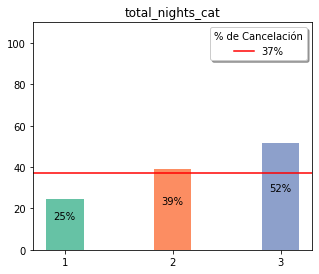

In [0]:
plotVScanceled (df_cancelby_total_nights_cat);

### Feature 'market_segment'

En esta sección se analiza la tasa de cancelación en función del segmento de mercado.

In [0]:
df_cancelby_market_segment = df.groupby(["is_canceled","market_segment"])['market_segment'].count().unstack().transform(lambda x: (x * 100) / x.sum())
display(df['market_segment'].value_counts(), df_cancelby_market_segment)

online ta        59084
offline ta/to    24978
groups           20007
direct           13126
corporate         5786
aviation           232
complementary       34
undefined            1
Name: market_segment, dtype: int64

market_segment,aviation,complementary,corporate,direct,groups,offline ta/to,online ta,undefined
is_canceled,,,,,,,,
0,78.02,88.24,82.28,84.98,39.93,66.56,63.21,nan
1,21.98,11.76,17.72,15.02,60.07,33.44,36.79,100.00


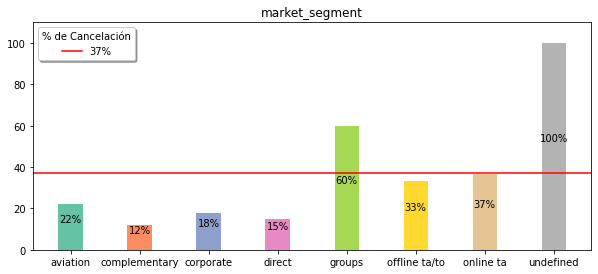

In [0]:
plotVScanceled (df_cancelby_market_segment);

### Feature 'distribution_channel'

En esta sección se analiza la tasa de cancelación en función del canal de distribucion

In [0]:
df_cancelby_distribution_channel = df.groupby(["is_canceled","distribution_channel"])['distribution_channel'].count().unstack().transform(lambda x: (x * 100) / x.sum())
display(df['distribution_channel'].value_counts(), df_cancelby_distribution_channel)

ta/to        101415
direct        14576
corporate      7064
gds             190
undefined         3
Name: distribution_channel, dtype: int64

distribution_channel,corporate,direct,gds,ta/to,undefined
is_canceled,,,,,
0,79.05,82.69,81.05,59.45,33.33
1,20.95,17.31,18.95,40.55,66.67


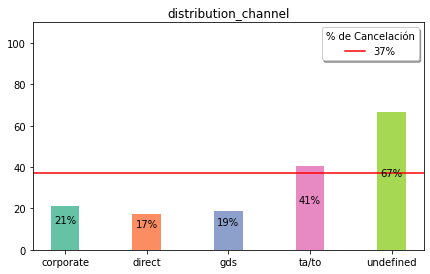

In [0]:
plotVScanceled (df_cancelby_distribution_channel);

### Feature 'adults', 'childs' y 'babies

In [0]:
df_cancelby_children = df.groupby(["is_canceled","children"])['children'].count().unstack().transform(lambda x: (x * 100) / x.sum())
df_cancelby_babies = df.groupby(["is_canceled","babies"])['babies'].count().unstack().transform(lambda x: (x * 100) / x.sum())
df_cancelby_adults = df.groupby(["is_canceled","adults"])['adults'].count().unstack().transform(lambda x: (x * 100) / x.sum())

def f(row):
    if row['childs'] > 0:
        val = 1
    else:
        val = 0
    return val

def f(row):
    if row['babies'] > 0:
        val = 1
    else:
        val = 0
    return val


df['childs'] = df['children'] + df['babies']
df['has_childs'] = df.apply(f, axis=1)

df['has_baby'] = df.apply(f, axis=1)

df_cancelby_childs = df.groupby(["is_canceled","childs"])['childs'].count().unstack().transform(lambda x: (x * 100) / x.sum())
df_cancelby_has_childs = df.groupby(["is_canceled","has_childs"])['has_childs'].count().unstack().transform(lambda x: (x * 100) / x.sum())
df_cancelby_has_baby = df.groupby(["is_canceled","has_baby"])['has_baby'].count().unstack().transform(lambda x: (x * 100) / x.sum())


display(df_cancelby_children,
        df_cancelby_babies,
        df_cancelby_adults,
        df_cancelby_childs,
        df_cancelby_has_childs,
        df_cancelby_has_baby,
        is_canceled_chart)

children,0.00,1.00,2.00,3.00,10.00
is_canceled,,,,,
0,63.33,67.92,57.87,74.32,nan
1,36.67,32.08,42.13,25.68,100.00


babies,0,1,2,9,10
is_canceled,,,,,
0,63.22,81.96,88.89,100.00,100.00
1,36.78,18.04,11.11,nan,nan


adults,0,1,2,3,4
is_canceled,,,,,
0,63.80,71.30,61.23,64.98,74.60
1,36.20,28.70,38.77,35.02,25.40


childs,0.00,1.00,2.00,3.00,9.00,10.00
is_canceled,,,,,,
0,63.20,69.34,58.97,70.75,100.00,50.00
1,36.80,30.66,41.03,29.25,nan,50.00


has_childs,0,1
is_canceled,,
0,63.22,82.13
1,36.78,17.87


has_baby,0,1
is_canceled,,
0,63.22,82.13
1,36.78,17.87


0   0.63
1   0.37
Name: is_canceled, dtype: float64

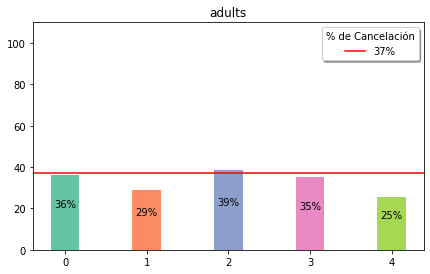

In [0]:
plotVScanceled (df_cancelby_adults);

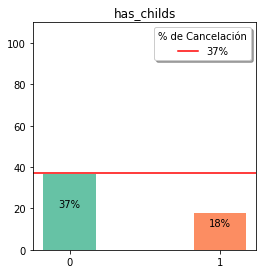

In [0]:
plotVScanceled (df_cancelby_has_childs);

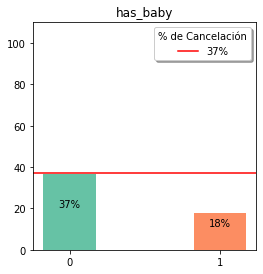

In [0]:
plotVScanceled (df_cancelby_has_baby);

### Feature que habla de las cancelaciones previas

In [0]:
df_cancelby_previous_bookings_not_canceled = df.groupby(["is_canceled","previous_bookings_not_canceled"])['previous_bookings_not_canceled'].count().unstack().transform(lambda x: (x * 100) / x.sum())
df_cancelby_previous_cancellations = df.groupby(["is_canceled","previous_cancellations"])['previous_cancellations'].count().unstack().transform(lambda x: (x * 100) / x.sum())

def f(row):
    if row['previous_cancellations'] > 13:
        val = 1
    else:
        val = 0
    return val
df['has_previous_cancellations'] = df.apply(f, axis=1)

def f(row):
    if row['previous_bookings_not_canceled'] > 0:
        val = 1
    else:
        val = 0
    return val
df['has_previous_bookings_not_canceled'] = df.apply(f, axis=1)


df_cancelby_has_previous_cancellations = df.groupby(["is_canceled","has_previous_cancellations"])['has_previous_cancellations'].count().unstack().transform(lambda x: (x * 100) / x.sum())
df_cancelby_has_previous_bookings_not_canceled = df.groupby(["is_canceled","has_previous_bookings_not_canceled"])['has_previous_bookings_not_canceled'].count().unstack().transform(lambda x: (x * 100) / x.sum())

display(df['has_previous_cancellations'].value_counts(),
        df['has_previous_bookings_not_canceled'].value_counts(), 
        df_cancelby_previous_bookings_not_canceled,
        df_cancelby_previous_cancellations,
        df_cancelby_has_previous_cancellations,
        df_cancelby_has_previous_bookings_not_canceled,
        is_canceled_chart)




0    123139
1       109
Name: has_previous_cancellations, dtype: int64

0    119287
1      3961
Name: has_previous_bookings_not_canceled, dtype: int64

previous_bookings_not_canceled,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,62.32,95.00,94.21,94.04,94.07,93.97,97.41,95.56,95.95,100.00,90.38,92.86,90.62,92.00,91.30,93.75,95.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,50.00,83.33,75.00,100.00,87.50,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,50.00,100.00,100.00,100.00,50.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,50.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
1,37.68,5.00,5.79,5.96,5.93,6.03,2.59,4.44,4.05,nan,9.62,7.14,9.38,8.00,8.70,6.25,5.00,nan,nan,nan,nan,nan,nan,nan,nan,50.00,16.67,25.00,nan,12.50,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,50.00,nan,nan,nan,50.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,50.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


previous_cancellations,0,1,2,3,4,5,6,11,13,14,19,21,24,25,26
is_canceled,,,,,,,,,,,,,,,
0,66.41,5.73,63.21,69.64,75.00,85.71,68.18,71.43,9.09,nan,nan,nan,nan,nan,nan
1,33.59,94.27,36.79,30.36,25.00,14.29,31.82,28.57,90.91,100.00,100.00,100.00,100.00,100.00,100.00


has_previous_cancellations,0,1
is_canceled,,
0,63.41,nan
1,36.59,100.00


has_previous_bookings_not_canceled,0,1
is_canceled,,
0,62.32,94.52
1,37.68,5.48


0   0.63
1   0.37
Name: is_canceled, dtype: float64

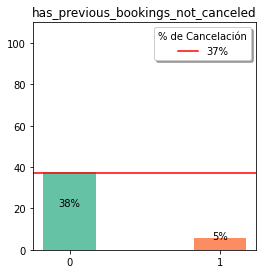

In [0]:
plotVScanceled (df_cancelby_has_previous_bookings_not_canceled);

### Feature en función del 'room_type'

Para no aumentar la cantidad de dimensiones, se crear una feature que toma el valor 1 si el tipo de habitación asignada, coincide con el tipo de habitación reservada.

In [0]:
def f(row):
    if row['reserved_room_type'] == row['assigned_room_type']:
        val = 0
    else:
        val = 1
    return val

df['has_room_change'] = df.apply(f, axis=1)

df_cancelby_has_room_change = df.groupby(["is_canceled","has_room_change"])['has_room_change'].count().unstack().transform(lambda x: (x * 100) / x.sum())
display(df['has_room_change'].value_counts(), df_cancelby_has_room_change, is_canceled_chart)


0    108081
1     15167
Name: has_room_change, dtype: int64

has_room_change,0,1
is_canceled,,
0,58.97,94.65
1,41.03,5.35


0   0.63
1   0.37
Name: is_canceled, dtype: float64

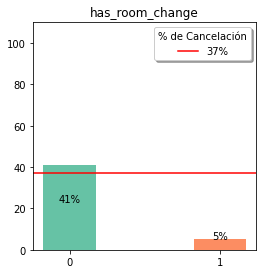

In [0]:
plotVScanceled (df_cancelby_has_room_change);

Como se puede apreciar, la tasa de cancelación varía notablemente entre ambas categorías.

### Feature 'average_d_rate'

Como ya se vio al principio, las reservas del hotel presentan varios daily rates. Por eso se propone categorizarlos.

In [0]:
df['average_d_rate_cat'] = pd.cut(df['average_d_rate'], bins =[0, 71, 104, 126, 5500] , labels=["1", "2", "3", '4']).values

df_cancelby_average_d_rate_cat = df.groupby(["is_canceled","average_d_rate_cat"])['average_d_rate_cat'].count().unstack().transform(lambda x: (x * 100) / x.sum())

display(df_cancelby_average_d_rate_cat,
        is_canceled_chart)


average_d_rate_cat,1,2,3,4
is_canceled,,,,
0,66.54,62.94,62.12,61.51
1,33.46,37.06,37.88,38.49


0   0.63
1   0.37
Name: is_canceled, dtype: float64

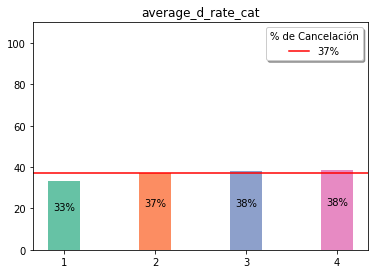

In [0]:
plotVScanceled (df_cancelby_average_d_rate_cat);

En este caso se puede ver que entre las categorías del los daily rates, no parece haber mucha diferencia en las tasas de cancelación, por lo que **no se tomará como una feature.**

### Feature 'is_repeated_guest'

Se analiza la feature que nos indica si quien hizo la reserva, ya había sigo un guest anteriormente.

In [0]:
df_cancelby_is_repeated_guest = df.groupby(["is_canceled","is_repeated_guest"])['is_repeated_guest'].count().unstack().transform(lambda x: (x * 100) / x.sum())

display(df['is_repeated_guest'].value_counts(), 
        df_cancelby_is_repeated_guest)

0    119971
1      3277
Name: is_repeated_guest, dtype: int64

is_repeated_guest,0,1
is_canceled,,
0,62.80,83.95
1,37.20,16.05


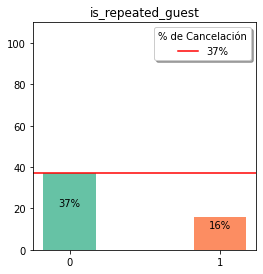

In [0]:
plotVScanceled (df_cancelby_is_repeated_guest);

En este caso, se ve diferencia entre los tipos de 'guest' por lo que se mantiene esta feature.

### Feature 'required_car_parking_spaces'

Se analiza la feature que nos indica la cantidad de cocheras que fueron reservadas. Para no aumentar la cantidad de columnas, se transforma en un 1 si reservó al menos 1 cochera, o 0 si no reservó ninguna.

In [0]:
df_cancelby_required_car_parking_spaces = df.groupby(["is_canceled","required_car_parking_spaces"])['required_car_parking_spaces'].count().unstack().transform(lambda x: (x * 100) / x.sum())

def f(row):
    if row['required_car_parking_spaces'] > 0:
        val = 1
    else:
        val = 0
    return val

df['requires_parking'] = df.apply(f, axis=1)

df_cancelby_requires_parking = df.groupby(["is_canceled","requires_parking"])['requires_parking'].count().unstack().transform(lambda x: (x * 100) / x.sum())

display(df['requires_parking'].value_counts(), 
        df_cancelby_required_car_parking_spaces,
        df_cancelby_requires_parking)

0    115268
1      7980
Name: requires_parking, dtype: int64

required_car_parking_spaces,0,1,2,3,8
is_canceled,,,,,
0,60.82,100.00,100.00,100.00,100.00
1,39.18,nan,nan,nan,nan


requires_parking,0,1
is_canceled,,
0,60.82,100.00
1,39.18,nan


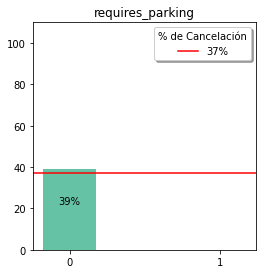

In [0]:
plotVScanceled (df_cancelby_requires_parking);

Se puede ver que nignuno de los que reservó cochera, cancelo, por lo  tanto vamos a mantener esta feature.

### Feature 'total_of_sepcial_request'

Se analiza la feature que nos indica la cantidad de requerimientos especiales solicitados por el huespued. Para no aumentar la cantidad de columnas, se transforma en un 1 si tuvo al menos 1, o 0 en caso contrario.

In [0]:
df_cancelby_total_of_special_requests = df.groupby(["is_canceled", "total_of_special_requests"])['total_of_special_requests'].count().unstack().transform(lambda x: (x * 100) / x.sum())

def f(row):
    if row['total_of_special_requests'] > 0:
        val = 1
    else:
        val = 0
    return val

df['has_special_requests'] = df.apply(f, axis=1)

df_cancelby_has_special_requests= df.groupby(["is_canceled","has_special_requests"])['has_special_requests'].count().unstack().transform(lambda x: (x * 100) / x.sum())


display(df['has_special_requests'].value_counts(), 
        df_cancelby_total_of_special_requests,
        df_cancelby_has_special_requests,
        is_canceled_chart)

0    72026
1    51222
Name: has_special_requests, dtype: int64

total_of_special_requests,0,1,2,3,4,5
is_canceled,,,,,,
0,52.75,78.00,78.02,81.66,88.69,89.13
1,47.25,22.00,21.98,18.34,11.31,10.87


has_special_requests,0,1
is_canceled,,
0,52.75,78.27
1,47.25,21.73


0   0.63
1   0.37
Name: is_canceled, dtype: float64

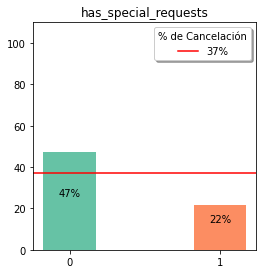

In [0]:
plotVScanceled (df_cancelby_has_special_requests);

Como se puede ver las dos categorías presentan diferencias, por lo que se mantiene la feature creada.

### Feature 'booking_changes'

Se analiza la feature que nos indica la cantidad de cambios en la reserva realizados por el huespued. Para no aumentar la cantidad de columnas, se transforma en un 1 si tuvo al menos 1, o 0 en caso contrario.

In [0]:
df_cancelby_booking_changes = df.groupby(["is_canceled", "booking_changes"])['booking_changes'].count().unstack().transform(lambda x: (x * 100) / x.sum())

def f(row):
    if row['booking_changes'] > 0:
        val = 1
    else:
        val = 0
    return val

df['has_booking_changes'] = df.apply(f, axis=1)

df_cancelby_has_booking_changes= df.groupby(["is_canceled","has_booking_changes"])['has_booking_changes'].count().unstack().transform(lambda x: (x * 100) / x.sum())

display(df['has_booking_changes'].value_counts(), 
        df_cancelby_booking_changes,
        df_cancelby_has_booking_changes,
        is_canceled_chart)

0    104892
1     18356
Name: has_booking_changes, dtype: int64

booking_changes,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
is_canceled,,,,,,,,,,,,,,,,,,,
0,59.71,85.80,79.57,83.71,80.81,82.61,68.42,88.89,69.23,85.71,80.00,100.00,100.00,100.00,66.67,100.00,50.00,100.00,100.00
1,40.29,14.20,20.43,16.29,19.19,17.39,31.58,11.11,30.77,14.29,20.00,nan,nan,nan,33.33,nan,50.00,nan,nan


has_booking_changes,0,1
is_canceled,,
0,59.71,84.19
1,40.29,15.81


0   0.63
1   0.37
Name: is_canceled, dtype: float64

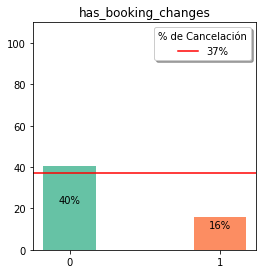

In [0]:
plotVScanceled (df_cancelby_has_booking_changes);

Se puede ver diferencia en las categorías por lo tanto se mantiene la feature.

### Feature 'days_in_waiting_list'

Se analiza la feature que nos indica la cantidad de dias que el huespued estuvo en la lista de espera. Para no aumentar la cantidad de columnas, se transforma en un 1 si estuvo al menos 1 día, o 0 en caso contrario.

In [0]:
df_cancelby_days_in_waiting_list = df.groupby(["is_canceled", "days_in_waiting_list"])['days_in_waiting_list'].count().unstack().transform(lambda x: (x * 100) / x.sum())

def f(row):
    if row['days_in_waiting_list'] > 0:
        val = 1
    else:
        val = 0
    return val

df['has_days_in_waiting_list'] = df.apply(f, axis=1)

df_cancelby_has_days_in_waiting_list= df.groupby(["is_canceled","has_days_in_waiting_list"])['has_days_in_waiting_list'].count().unstack().transform(lambda x: (x * 100) / x.sum())

display(df['has_days_in_waiting_list'].value_counts(), 
        df_cancelby_days_in_waiting_list,
        df_cancelby_has_days_in_waiting_list,
        is_canceled_chart)

0    119566
1      3682
Name: has_days_in_waiting_list, dtype: int64

days_in_waiting_list,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,52,53,54,55,56,57,58,59,60,61,62,63,64,65,68,69,70,71,72,73,74,75,76,77,79,80,81,83,84,85,87,89,91,93,96,97,98,99,100,101,105,107,108,109,111,113,116,117,120,121,122,125,142,147,150,154,160,162,165,167,174,175,176,178,183,185,187,193,207,215,223,224,236,259,330,379,391
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,64.20,75.00,80.00,nan,68.00,37.50,100.00,25.00,42.86,12.50,3.57,42.86,66.67,75.00,62.50,46.30,nan,21.28,33.33,nan,6.90,2.70,7.02,33.33,nan,34.62,nan,88.00,2.00,nan,0.81,nan,96.67,53.85,2.08,100.00,100.00,60.27,nan,32.14,nan,nan,94.44,20.57,nan,1.09,95.83,67.80,94.44,38.75,100.00,83.33,nan,nan,47.73,nan,100.00,64.29,9.76,94.44,nan,63.22,100.00,100.00,29.27,17.98,nan,nan,100.00,nan,100.00,48.72,nan,58.73,nan,29.17,100.00,100.00,50.00,nan,95.00,100.00,nan,2.50,54.35,100.00,48.21,78.95,33.33,26.15,100.00,40.00,40.00,100.00,16.90,83.33,100.00,nan,nan,nan,100.00,93.33,100.00,70.00,100.00,100.00,nan,43.33,nan,100.00,21.05,nan,78.00,83.33,nan,100.00,48.89,nan,66.67,38.10,59.02,40.00,82.86,100.00,93.33,40.00,nan
1,35.80,25.00,20.00,100.00,32.00,62.50,nan,75.00,57.14,87.50,96.43,57.14,33.33,25.00,37.50,53.70,100.00,78.72,66.67,100.00,93.10,97.30,92.98,66.67,100.00,65.38,100.00,12.00,98.00,100.00,99.19,100.00,3.33,46.15,97.92,nan,nan,39.73,100.00,67.86,100.00,100.00,5.56,79.43,100.00,98.91,4.17,32.20,5.56,61.25,nan,16.67,100.00,100.00,52.27,100.00,nan,35.71,90.24,5.56,100.00,36.78,nan,nan,70.73,82.02,100.00,100.00,nan,100.00,nan,51.28,100.00,41.27,100.00,70.83,nan,nan,50.00,100.00,5.00,nan,100.00,97.50,45.65,nan,51.79,21.05,66.67,73.85,nan,60.00,60.00,nan,83.10,16.67,nan,100.00,100.00,100.00,nan,6.67,nan,30.00,nan,nan,100.00,56.67,100.00,nan,78.95,100.00,22.00,16.67,100.00,nan,51.11,100.00,33.33,61.90,40.98,60.00,17.14,nan,6.67,60.00,100.00


has_days_in_waiting_list,0,1
is_canceled,,
0,64.20,36.12
1,35.80,63.88


0   0.63
1   0.37
Name: is_canceled, dtype: float64

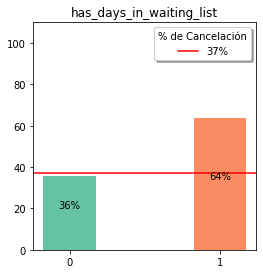

In [0]:
plotVScanceled (df_cancelby_has_days_in_waiting_list);

Se ve que hay diferencia entre las categorías por lo tanto se mantiene la feature

### Feature 'agent'

Se analiza la feature que nos indica la cantidad de cambios en la reserva realizados por el huespued. Para no aumentar la cantidad de columnas, se transforma en un 1 si tuvo al menos 1, o 0 en caso contrario.

In [0]:
df_cancelby_agent = df.groupby(["is_canceled", "agent"])['agent'].count().unstack().transform(lambda x: (x * 100) / x.sum())

def f(row):
    if row['agent'] > 0:
        val = 1
    else:
        val = 0
    return val

df['has_agent'] = df.apply(f, axis=1)

df_cancelby_has_agent= df.groupby(["is_canceled","has_agent"])['has_agent'].count().unstack().transform(lambda x: (x * 100) / x.sum())


df_cancelby_company = df.groupby(["is_canceled", "company"])['company'].count().unstack().transform(lambda x: (x * 100) / x.sum())

def f(row):
    if row['company'] > 0:
        val = 1
    else:
        val = 0
    return val

df['has_company'] = df.apply(f, axis=1)

df_cancelby_has_company= df.groupby(["is_canceled","has_company"])['has_company'].count().unstack().transform(lambda x: (x * 100) / x.sum())


display(df['has_company'].value_counts(), 
        df_cancelby_agent,
        df_cancelby_has_agent,
        df_cancelby_company,
        df_cancelby_has_company,
        is_canceled_chart)


0    116353
1      6895
Name: has_company, dtype: int64

agent,1.00,2.00,3.00,4.00,5.00,6.00,7.00,8.00,9.00,10.00,11.00,12.00,13.00,14.00,15.00,16.00,17.00,19.00,20.00,21.00,22.00,23.00,24.00,25.00,26.00,27.00,28.00,29.00,30.00,31.00,32.00,33.00,34.00,35.00,36.00,37.00,38.00,39.00,40.00,41.00,42.00,44.00,45.00,47.00,50.00,52.00,53.00,54.00,55.00,56.00,57.00,58.00,59.00,60.00,61.00,63.00,64.00,66.00,67.00,68.00,69.00,70.00,71.00,72.00,73.00,74.00,75.00,77.00,78.00,79.00,81.00,82.00,83.00,85.00,86.00,87.00,88.00,89.00,90.00,91.00,92.00,93.00,94.00,95.00,96.00,98.00,99.00,103.00,104.00,105.00,106.00,107.00,110.00,111.00,112.00,114.00,115.00,117.00,118.00,119.00,121.00,122.00,126.00,127.00,128.00,129.00,132.00,133.00,134.00,135.00,138.00,139.00,141.00,142.00,143.00,144.00,146.00,147.00,148.00,149.00,150.00,151.00,152.00,153.00,154.00,155.00,156.00,157.00,158.00,159.00,162.00,163.00,165.00,167.00,168.00,170.00,171.00,173.00,174.00,175.00,177.00,179.00,180.00,181.00,182.00,183.00,184.00,185.00,187.00,191.00,192.00,193.00,195.00,196.00,197.00,201.00,205.00,208.00,210.00,211.00,213.00,214.00,215.00,216.00,219.00,220.00,223.00,227.00,229.00,232.00,234.00,235.00,236.00,240.00,241.00,242.00,243.00,244.00,245.00,247.00,248.00,249.00,250.00,251.00,252.00,253.00,254.00,256.00,257.00,258.00,261.00,262.00,265.00,267.00,269.00,270.00,273.00,275.00,276.00,278.00,280.00,281.00,282.00,283.00,285.00,286.00,287.00,288.00,289.00,290.00,291.00,294.00,295.00,296.00,298.00,299.00,300.00,301.00,303.00,304.00,305.00,306.00,307.00,308.00,310.00,313.00,314.00,315.00,321.00,323.00,324.00,325.00,326.00,327.00,328.00,330.00,331.00,332.00,333.00,334.00,335.00,336.00,337.00,339.00,341.00,344.00,346.00,348.00,350.00,352.00,354.00,355.00,358.00,359.00,360.00,363.00,364.00,367.00,368.00,370.00,371.00,375.00,378.00,384.00,385.00,387.00,388.00,390.00,391.00,393.00,394.00,397.00,403.00,404.00,405.00,406.00,408.00,410.00,411.00,414.00,416.00,418.00,420.00,423.00,425.00,426.00,427.00,429.00,430.00,431.00,432.00,433.00,434.00,436.00,438.00,440.00,441.00,444.00,446.00,449.00,450.00,451.00,453.00,454.00,455.00,459.00,461.00,464.00,467.00,468.00,469.00,472.00,474.00,475.00,476.00,479.00,480.00,481.00,483.00,484.00,492.00,493.00,495.00,497.00,502.00,508.00,509.00,510.00,526.00,527.00,531.00,535.00
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,25.56,84.13,42.93,31.82,56.81,68.94,87.38,72.88,57.92,75.58,73.62,43.93,71.43,81.67,72.35,92.31,51.68,26.87,32.00,41.89,88.51,92.00,100.00,100.00,66.75,89.96,93.30,19.94,60.62,4.94,92.86,10.71,38.70,39.25,95.33,41.89,48.12,67.86,91.78,nan,85.99,20.27,100.00,46.94,66.67,73.97,22.22,100.00,nan,31.27,67.86,11.94,100.00,nan,100.00,100.00,4.35,81.82,38.21,20.67,96.55,100.00,45.83,100.00,100.00,100.00,87.32,94.74,28.21,85.11,83.33,51.72,73.04,80.22,41.49,56.41,100.00,94.74,100.00,94.74,100.00,nan,85.25,85.94,76.63,50.00,62.69,90.48,90.57,76.47,100.00,nan,73.33,87.50,100.00,100.00,94.55,100.00,58.21,29.90,91.89,100.00,85.71,97.62,91.30,92.86,68.35,64.49,37.95,100.00,87.09,90.91,100.00,67.88,90.06,100.00,91.85,72.08,100.00,64.29,100.00,47.27,96.79,76.00,30.26,42.86,89.84,87.50,100.00,89.66,nan,100.00,100.00,100.00,92.15,nan,71.99,89.66,86.36,75.76,76.66,50.00,100.00,73.77,14.29,66.67,81.48,88.31,91.30,51.64,17.07,100.00,80.42,81.31,100.00,98.04,85.19,44.58,85.71,100.00,100.00,40.00,93.33,100.00,84.62,99.01,100.00,100.00,39.32,100.00,59.84,nan,nan,60.51,88.27,67.90,94.50,85.71,29.73,100.00,35.66,39.58,82.06,90.95,10.34,81.93,75.86,95.45,nan,100.00,78.38,84.31,100.00,100.00,100.00,83.33,63.99,75.00,nan,100.00,100.00,34.57,100.00,100.00,100.00,nan,nan,100.00,100.00,83.33,nan,100.00,100.00,73.33,69.59,100.00,100.00,100.00,100.00,100.00,41.86,95.00,46.15,100.00,17.86,94.44,83.65,62.82,100.00,nan,88.89,100.00,2

has_agent,0,1
is_canceled,,
0,76.10,61.40
1,23.90,38.60


company,6.00,8.00,9.00,10.00,11.00,12.00,14.00,16.00,18.00,20.00,22.00,28.00,29.00,31.00,32.00,34.00,37.00,38.00,39.00,40.00,42.00,43.00,45.00,46.00,47.00,48.00,49.00,51.00,52.00,53.00,54.00,59.00,61.00,62.00,64.00,65.00,67.00,68.00,71.00,72.00,73.00,76.00,77.00,78.00,80.00,81.00,82.00,83.00,84.00,85.00,86.00,88.00,91.00,92.00,93.00,94.00,96.00,99.00,100.00,101.00,102.00,103.00,104.00,105.00,106.00,107.00,108.00,109.00,110.00,112.00,113.00,115.00,116.00,118.00,120.00,122.00,127.00,130.00,132.00,135.00,137.00,139.00,140.00,142.00,143.00,144.00,146.00,148.00,149.00,150.00,153.00,154.00,158.00,159.00,160.00,163.00,165.00,167.00,168.00,169.00,174.00,178.00,179.00,180.00,183.00,184.00,185.00,186.00,192.00,193.00,195.00,197.00,200.00,202.00,203.00,204.00,207.00,209.00,210.00,212.00,213.00,215.00,216.00,217.00,218.00,219.00,220.00,221.00,222.00,223.00,224.00,225.00,227.00,229.00,230.00,232.00,233.00,237.00,238.00,240.00,242.00,243.00,245.00,246.00,250.00,251.00,253.00,254.00,255.00,257.00,258.00,259.00,260.00,263.00,264.00,268.00,269.00,270.00,271.00,272.00,273.00,274.00,275.00,277.00,278.00,280.00,281.00,282.00,284.00,286.00,287.00,289.00,290.00,291.00,292.00,293.00,297.00,301.00,302.00,304.00,305.00,307.00,308.00,309.00,311.00,312.00,313.00,316.00,317.00,318.00,319.00,320.00,321.00,323.00,324.00,325.00,329.00,330.00,331.00,332.00,333.00,337.00,338.00,341.00,342.00,343.00,346.00,347.00,348.00,349.00,350.00,351.00,352.00,353.00,355.00,356.00,357.00,358.00,360.00,361.00,362.00,364.00,365.00,366.00,367.00,368.00,369.00,371.00,372.00,373.00,376.00,377.00,378.00,379.00,380.00,383.00,384.00,385.00,388.00,390.00,391.00,392.00,393.00,394.00,395.00,396.00,397.00,398.00,399.00,400.00,401.00,402.00,403.00,405.00,407.00,408.00,409.00,410.00,411.00,412.00,413.00,415.00,416.00,417.00,418.00,419.00,420.00,421.00,422.00,423.00,424.00,425.00,426.00,428.00,429.00,433.00,435.00,436.00,437.00,439.00,442.00,443.00,444.00,445.00,446.00,447.00,448.00,450.00,451.00,452.00,454.00,455.00,456.00,457.00,458.00,459.00,460.00,461.00,465.00,466.00,470.00,477.00,478.00,479.00,481.00,482.00,483.00,484.00,485.00,486.00,487.00,489.00,490.00,491.00,492.00,494.00,496.00,497.00,498.00,499.00,501.00,504.00,506.00,507.00,511.00,512.00,513.00,514.00,515.00,516.00,518.00,520.00,521.00,523.00,525.00,528.00,530.00,531.00,534.00,539.00,541.00,543.00
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,100.00,100.00,95.45,100.00,100.00,100.00,88.89,100.00,100.00,76.09,100.00,100.00,100.00,78.12,100.00,87.50,nan,81.58,71.43,91.65,100.00,51.35,100.00,87.50,84.06,nan,100.00,67.89,100.00,75.00,100.00,90.00,100.00,94.34,100.00,100.00,34.46,82.61,100.00,100.00,66.67,100.00,nan,95.24,100.00,82.76,76.00,77.78,100.00,50.00,81.82,81.82,91.49,100.00,66.67,87.12,100.00,90.91,100.00,100.00,nan,100.00,100.00,100.00,100.00,88.89,100.00,100.00,66.00,81.25,92.86,75.00,100.00,100.00,93.33,nan,93.33,91.67,100.00,76.19,100.00,100.00,100.00,100.00,52.94,100.00,100.00,94.59,100.00,90.48,77.51,96.77,100.00,100.00,100.00,100.00,100.00,100.00,100.00,76.12,85.62,93.33,66.67,100.00,100.00,100.00,100.00,91.67,100.00,100.00,90.91,25.53,100.00,nan,90.00,84.62,88.89,88.89,100.00,100.00,100.00,100.00,85.71,100.00,76.60,93.48,100.00,88.89,100.00,84.84,83.33,100.00,91.67,100.00,100.00,100.00,90.76,100.00,90.91,100.00,98.33,100.00,100.00,100.00,50.00,94.74,nan,90.00,100.00,100.00,100.00,100.00,100.00,91.67,100.00,100.00,94.74,85.71,100.00,100.00,100.00,92.86,66.67,50.00,100.00,65.31,87.22,100.00,100.00,85.71,100.00,100.00,100.00,100.00,74.07,100.00,100.00,100.00,100.00,100.00,100.00,94.74,61.29,nan,100.00,100.00,100.00,nan,91.67,100.00,100.00,100.00,nan,100.00,88.89,100.00,75.00,100.00,80.00,100.00,100.00,95.65,100

has_company,0,1
is_canceled,,
0,62.20,82.97
1,37.80,17.03


0   0.63
1   0.37
Name: is_canceled, dtype: float64

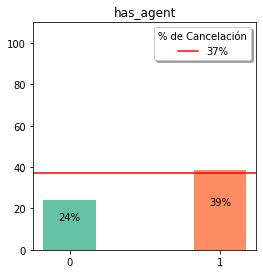

In [0]:
plotVScanceled (df_cancelby_has_agent);

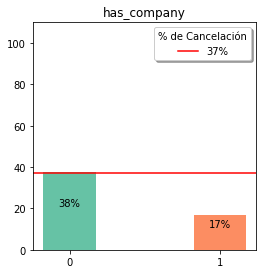

In [0]:
plotVScanceled (df_cancelby_has_company);

Se ve que hay diferencia entre las categorías por lo tanto se mantiene la feature

### Feature 'week_in_year_of_arrival'

Se analiza la feature que nos indica la semana en que se hizo la reserva.

In [0]:
df_cancelby_week_in_year_of_arrival = df.groupby(["is_canceled","week_in_year_of_arrival"])['week_in_year_of_arrival'].count().unstack().transform(lambda x: (x * 100) / x.sum())
display(df['week_in_year_of_arrival'].value_counts(), df_cancelby_week_in_year_of_arrival, is_canceled_chart)



33    3685
30    3236
32    3214
34    3122
28    3041
18    3031
21    3004
29    2912
31    2902
20    2856
17    2849
27    2834
41    2792
42    2783
38    2780
15    2774
25    2768
39    2739
23    2696
22    2681
35    2671
24    2600
40    2512
26    2489
13    2486
19    2472
16    2422
43    2414
44    2363
37    2320
14    2293
8     2248
36    2242
10    2210
12    2190
9     2165
11    2127
7     2118
45    1974
53    1829
49    1776
47    1704
46    1600
6     1567
4     1551
48    1507
50    1453
5     1405
3     1365
2     1231
52    1207
1     1079
51     959
Name: week_in_year_of_arrival, dtype: int64

week_in_year_of_arrival,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,65.71,67.02,75.46,66.92,68.97,75.11,67.61,65.08,66.14,65.97,70.10,69.68,64.32,63.67,61.90,58.88,57.39,55.06,64.16,56.30,64.55,60.91,59.68,60.50,54.05,64.68,63.13,63.93,63.60,59.92,64.65,62.76,58.24,66.02,64.47,62.27,62.03,61.94,63.71,59.39,59.78,59.58,62.84,68.43,61.04,63.31,77.64,74.98,62.84,59.12,74.35,69.68,64.30
1,34.29,32.98,24.54,33.08,31.03,24.89,32.39,34.92,33.86,34.03,29.90,30.32,35.68,36.33,38.10,41.12,42.61,44.94,35.84,43.70,35.45,39.09,40.32,39.50,45.95,35.32,36.87,36.07,36.40,40.08,35.35,37.24,41.76,33.98,35.53,37.73,37.97,38.06,36.29,40.61,40.22,40.42,37.16,31.57,38.96,36.69,22.36,25.02,37.16,40.88,25.65,30.32,35.70


0   0.63
1   0.37
Name: is_canceled, dtype: float64

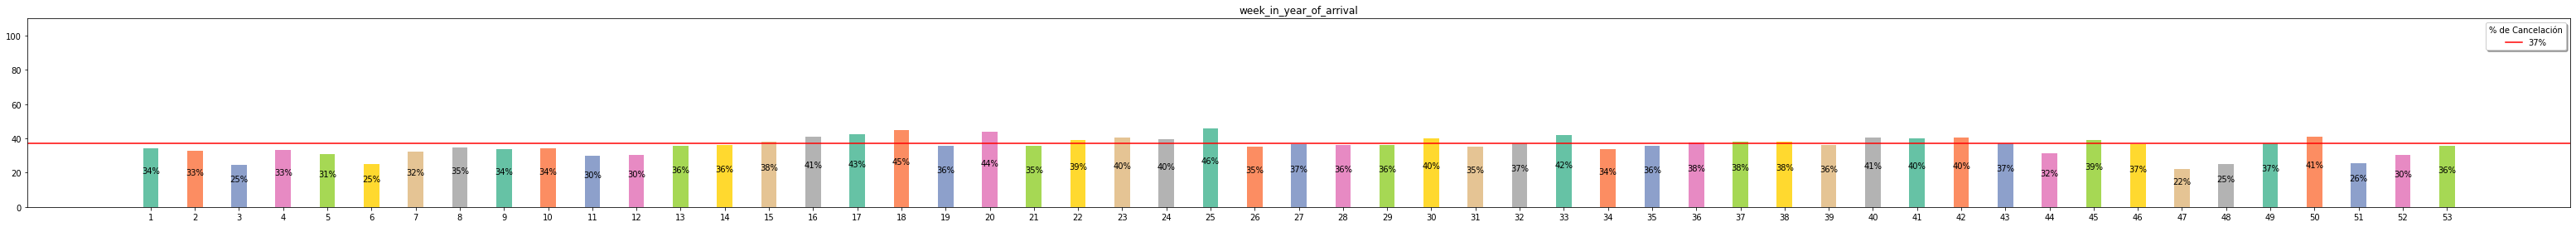

In [0]:
plotVScanceled (df_cancelby_week_in_year_of_arrival);

### Feature 'lead_time_days'

Se analiza la feature que nos indica la cantidad de días de anticipación con la que se hizo la reserva.

In [0]:
df_cancelby_lead_time_days = df.groupby(["is_canceled", "lead_time_days"])['lead_time_days'].count().unstack().transform(lambda x: (x * 100) / x.sum())

def f(row):
    if row['lead_time_days'] > 0:
        val = 1
    else:
        val = 0
    return val

#df['has_lead_time_days'] = df.apply(f, axis=1)

#df_cancelby_has_lead_time_days= df.groupby(["is_canceled","has_lead_time_days"])['has_lead_time_days'].count().unstack().transform(lambda x: (x * 100) / x.sum())
display(#df['has_lead_time_days'].value_counts(), 
        df_cancelby_lead_time_days,
        is_canceled_chart)

lead_time_days,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,393,394,395,396,397,398,399,400,403,405,406,407,408,409,410,411,412,414,418,419,420,422,423,424,426,429,433,434,435,437,440,443,444,445,447,448,450,451,454,457,458,460,461,462,463,464,465,467,468,471,475,476,478,479,482,489,490,493,496,503,504,507,510,517,518,521,524,531,532,538,542,545,552,559,566,573,580,587,594,601,605,608,615,622,626,629,709
is_canceled,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,94.00,91.46,89.88,89.97,90.07,87.08,86.73,87.46,81.19,78.41,77.09,79.16,74.66,79.24,77.79,68.57,75.31,73.49,68.10,68.98,70.98,70.66,68.93,67.48,72.39,67.22,64.66,62.86,58.31,70.96,63.10,71.55,66.15,63.42,61.09,68.22,69.81,53.08,50.84,65.50,68.35,67.25,65.48,68.75,60.73,61.64,63.53,72.70,74.81,60.41,59.38,64.21,58.62,70.66,55.23,67.34,47.30,68.80,62.36,58.17,60.50,57.43,61.02,67.15,67.32,55.60,61.24,59.34,53.83,60.25,66.84,53.62,65.19,61.99,55.13,58.51,64.57,59.51,57.28,61.58,64.85,68.68,59.02,70.87,78.32,60.44,60.00,43.85,56.42,62.65,73.31,60.22,42.86,53.31,62.14,53.81,63.96,57.80,62.50,49.54,54.60,54.87,54.80,47.03,42.96,43.33,43.40,72.39,60.57,55.38,59.16,54.01,60.61,37.99,62.64,60.05,63.07,62.34,73.37,69.80,54.72,57.88,70.21,59.17,58.19,56.35,58.11,60.08,59.69,50.81,51.17,57.46,70.37,70.76,51.78,53.52,66.67,55.90,65.43,49.78,59.41,65.40,52.49,48.89,53.54,61.42,58.17,55.13,40.14,46.23,50.15,61.90,70.98,56.13,73.54,47.92,48.11,55.51,50.00,73.62,61.09,39.06,50.33,54.96,55.22,61.48,44.44,61.75,49.07,56.60,54.09,70.32,58.43,54.95,52.40,45.26,63.31,55.40,37.46,50.83,62.88,52.01,50.97,48.37,51.18,66.38,45.88,58.49,39.26,59.91,61.59,74.47,74.50,48.43,71.21,51.04,57.93,58.47,42.62,49.55,49.65,53.95,64.96,63.68,58.39,45.83,66.31,60.65,66.50,55.88,42.66,41.70,48.82,52.65,59.88,66.36,52.94,63.72,48.62,46.85,71.81,58.48,54.90,56.95,59.23,73.79,47.96,61.11,55.13,44.14,60.00,56.57,57.83,37.50,59.42,48.78,68.24,52.10,33.08,45.34,36.31,63.25,48.08,44.23,40.00,34.96,36.00,44.44,63.75,49.12,46.00,68.32,63.16,54.37,76.47,54.84,84.24,74.81,30.00,24.16,30.69,45.37,31.34,49.00,51.56,48.70,47.06,16.00,40.00,44.19,46.96,71.59,40.00,45.62,25.62,17.79,36.67,20.44,19.57,9.09,28.21,15.20,

0   0.63
1   0.37
Name: is_canceled, dtype: float64

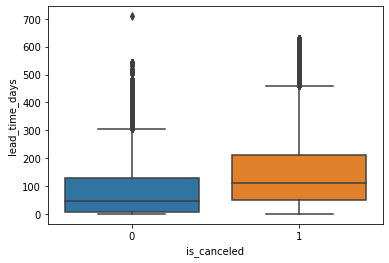

In [0]:
ax = sns.boxplot(x='is_canceled', y='lead_time_days', data=df)

Por lo que se puede ver, las reservas canceladas tienen más días de anticipación. Por lo que sería bueno categorizarlas.

In [0]:
df['lead_time_cat'] = pd.cut(df['lead_time_days'], bins =[0, 7,30, 180, 99999] , labels=["1", "2", "3", '4']).values

In [0]:
df_cancelby_lead_time_cat= df.groupby(["is_canceled","lead_time_cat"])['lead_time_cat'].count().unstack().transform(lambda x: (x * 100) / x.sum())
display(df['lead_time_cat'].value_counts(), 
        df_cancelby_lead_time_cat,
        is_canceled_chart)

3    58299
4    25610
2    19428
1    13690
Name: lead_time_cat, dtype: int64

lead_time_cat,1,2,3,4
is_canceled,,,,
0,89.42,72.07,59.50,44.17
1,10.58,27.93,40.50,55.83


0   0.63
1   0.37
Name: is_canceled, dtype: float64

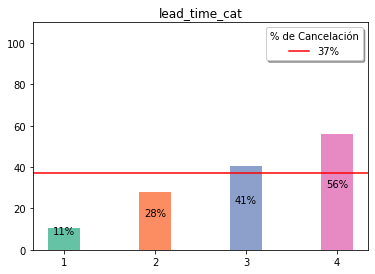

In [0]:
plotVScanceled (df_cancelby_lead_time_cat);

De forma clara, se puede ver como cada categoría tiene una tasa promedio de cancelación muy diferente.

### Resumen de features


In [0]:
columns_to_model = ['hotel', 
                    'is_canceled', 
                    'month_of_arrival',
                    'week_in_year_of_arrival',
                    'meal', 'market_segment',
                    'distribution_channel',
                    'is_repeated_guest', 
                    'deposit_type', 
                    'customer_type', 
                    'PBICat', 
                    'Continent_Name', 
                    'total_nights_cat', 
                    'has_previous_cancellations',
                    'has_previous_bookings_not_canceled', 
                    'has_childs',
                    'has_baby',
                    'has_room_change', 
                    'requires_parking',
                    'has_special_requests', 
                    'has_booking_changes',
                    'has_days_in_waiting_list', 
                    'has_agent', 
                    'has_company',
                    'lead_time_cat']

df_to_model = df[columns_to_model]

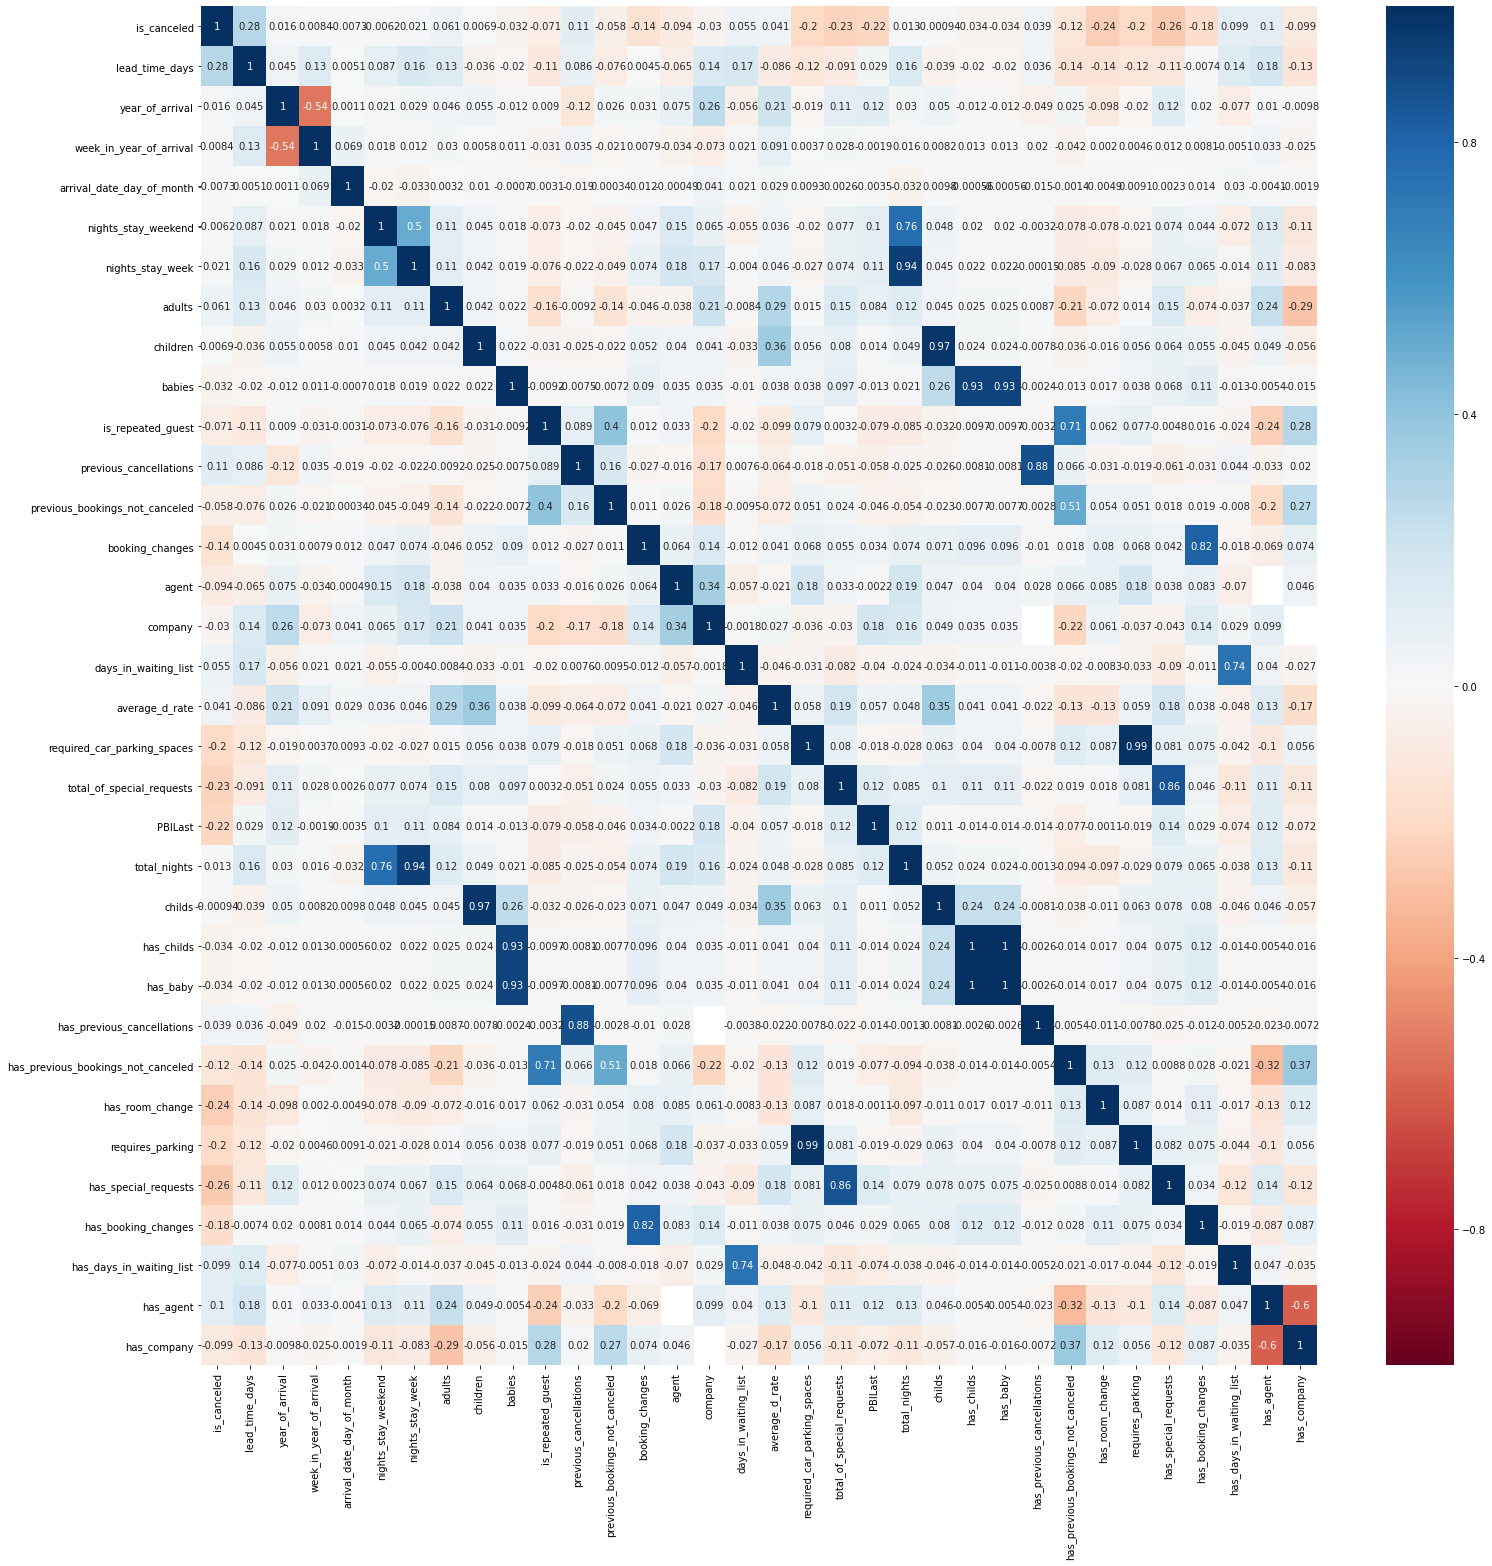

In [0]:
f,ax=plt.subplots(figsize=(25,25))
sns.heatmap(df.corr(), vmin=-1, vmax=1, center=0, cmap="RdBu", annot=True);

###  Generación de variables Dummies

In [0]:
def generate_dummies(df,columna,prefijo):
    dummies = pd.get_dummies(df[columna],prefix=prefijo,drop_first=True)
    df=df.join(dummies)
    return df

In [0]:
columns_to_dummy = ['hotel',
                    'Continent_Name', 
                    'deposit_type', 
                    'customer_type', 
                    'meal',
                    'week_in_year_of_arrival', #####
                    'month_of_arrival',
                    'total_nights_cat',
                    'market_segment',
                    'distribution_channel',
                    'PBICat',
                    'lead_time_cat']

In [0]:
for i in columns_to_dummy:
    df_to_model = generate_dummies(df_to_model,i,i)
    try:
        df_to_model = df_to_model.drop([i], axis=1)
    except:
        pass

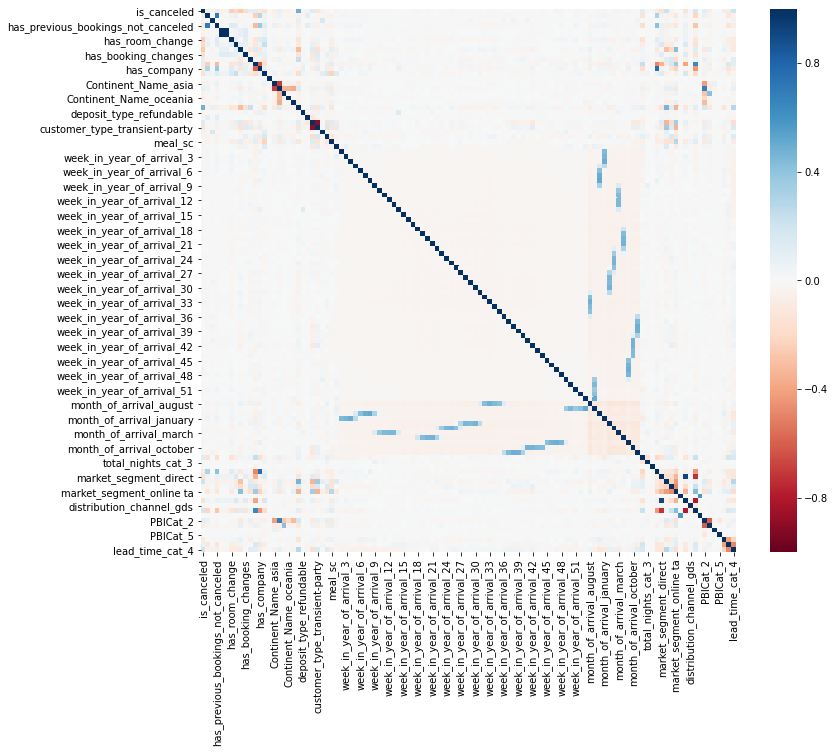

In [0]:
f,ax=plt.subplots(figsize=(12,10))
sns.heatmap(df_to_model.corr(), vmin=-1, vmax=1, center=0, cmap="RdBu");

### Reduccción de Dimensionalidad

In [0]:
# Este ciclo recorre todas las columnas y genera la X con todas ellas menos 'is_canceled'. Si se quisieran descartar
# Columnas, se agregar a la lista columnas_a_descartar

def creador_X(df, columnas_a_descartar):
    # se entrega la df a modelar completa y devuelve X (df sin columnas a descartar)
    X_columns = []
    for col in df.columns:
        if not col in columnas_a_descartar:
            X_columns.append(col)
        X = df[X_columns]
    return X
        

In [0]:
y = df_to_model['is_canceled']
columnas_a_descartar = ['is_canceled']
X = creador_X(df_to_model, columnas_a_descartar)


In [0]:
# Es fundamental hacer el train test split antes de transformar
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X, y, random_state=56,stratify=y)

In [0]:
# Normalizamos los datos utilizando el objeto StdSclr
# Hay que usar el método para transformarlo en un df porque el resultado de fit_transform no es un df
StdSclr = StandardScaler()
df_std = pd.DataFrame(StdSclr.fit_transform(X_train_pca), index=X_train_pca.index, columns=X_train_pca.columns)

In [0]:
# Instanciamos la clase PCA:
pca_hotel = PCA(n_components=len(X_train_pca.columns),svd_solver='full')

# Calculamos los componentes principales con el método fit()
pca_hotel.fit(df_std)

PCA(n_components=111, svd_solver='full')

In [0]:
lista = []
for i in enumerate(X_train_pca.columns):
    lista.append('PC{}'.format(i[0]))

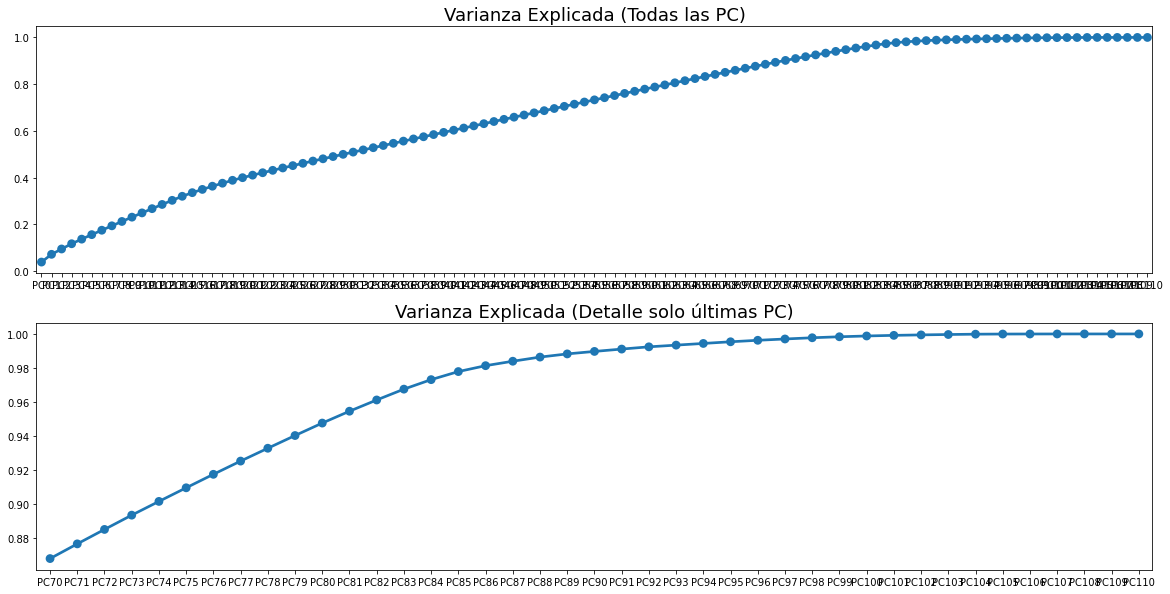

In [0]:
fig, axes = plt.subplots(2, 1, figsize=(20,10))
sns.pointplot(x=lista,y=np.cumsum(pca_hotel.explained_variance_ratio_),ax=axes[0])
sns.pointplot(x=lista[70:],y=np.cumsum(pca_hotel.explained_variance_ratio_)[70:])

axes[0].set_title('Varianza Explicada (Todas las PC)', fontsize=18); 
axes[1].set_title('Varianza Explicada (Detalle solo últimas PC)', fontsize=18)

plt.show()

Como se puede ver en el segundo chart, a partir de la PC 85, empieza a cambiar la pendiente de la curva. Es decir que podríamos reducir la dimensionalidad en 25 dimensiones. Se tendrá esto como opción ya que en principio la reducción no parece ser tan elevada.
Para eso se define una función que hace 3 cosas:
* Splitea en train y test
* Se fitea PCA con el set de train
* Se devuelven el X train y X test transformados por PCA

In [0]:
def transformar_x_con_pca(X,y,n_components=85):
    # Se genera el train test split (Porque el PCA se tiene que hacer con el set de train)
    X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X, y, random_state=56,test_size=testsize,stratify=y)
    
    
    # Normalizamos los datos utilizando el objeto StdSclr
    StdSclr = StandardScaler()
    X_train_std = pd.DataFrame(StdSclr.fit_transform(X_train_pca), index=X_train_pca.index, columns=X_train_pca.columns) 
    X_test_std = pd.DataFrame(StdSclr.transform(X_test_pca), index=X_test_pca.index, columns=X_test_pca.columns)    
    
    # Instanciamos la clase PCA:
    pca_hotel = PCA(n_components=n_components,svd_solver='full')
    
    # Fiteamos PCA
    pca_hotel.fit(X_train_std)
    
    # Después proyecta las componentes (Train y Test se transforman en base al fiteo de Train)
    X_train_pca = pca_hotel.transform(X_train_std)
    X_test_pca = pca_hotel.transform(X_test_std)
    
    lista = []
    for i in range(n_components):
        lista.append('PC{}'.format(i+1))
    lista
    
    # Se crear un dataset en funcion de las transformaciones
    X_train_pca = pd.DataFrame(X_train_pca, columns=lista)
    X_test_pca = pd.DataFrame(X_test_pca, columns=lista)
    
    return X_train_pca, X_test_pca, y_train_pca, y_test_pca

Para usar PCA, se debe pasar el X por esa funcion. Es fundamental que el X que se pase sea el mismo usado en el train test split de PCA.

# Seleccionando las mejores features para cada modelo

### Sacando el mejor K para KNN

In [0]:
df_knn = df_to_model.sample(20000,weights='is_canceled')
df_knn = df_knn.reset_index()
df_knn = df_knn.drop(['index'], axis=1)
columnas_a_descartar = ['is_canceled']
y = df_knn['is_canceled']
X = creador_X(df_knn, columnas_a_descartar)

splits = 5

In [0]:


def scores_knn(X,y,start,stop,step):
    
    # Voy a querer graficar los distintos valores del score de cross validation en función del hiperparámetro n_neighbors
    # Para esto voy a generar una lista de diccionarios que después se puede convertir fácilmente en DataFrame
    # Lista de Diccionarios
    
    scores_para_df = []
    
    # range(1,40,5) son los posibles valores de n_neighbors que quiero explorar. Son todos los enteros desde el 1
    # hasta el 40 en saltos de a 5. (Start,Stop,Step)
    
    for i in range(start,stop,step):
        # En cada iteración instanciamos el modelo con un hiperparámetro distinto
        
        #model = KNeighborsClassifier(n_neighbors=i, class_weight = "balanced")
        #print("Paso: "+ str(i))
        
        model = KNeighborsClassifier(n_neighbors=i)
        

        # cross_val_scores nos devuelve un array de 5 resultados, uno por cada partición que hizo automáticamente CV  
        
        kf = KFold(n_splits=splits, 
                   shuffle=True, 
                   random_state=10)
        
        cv_scores = cross_val_score(model, X, y, cv=kf)

        # Para cada valor de n_neighbours, creo un diccionario con el valor de n_neighbours y la media y el desvío de los scores.
        
        dict_row_score = {'score_medio':np.mean(cv_scores),'score_std':np.std(cv_scores),'n_neighbours':i}

        # Guardo cada uno en la lista de diccionarios
        
        scores_para_df.append(dict_row_score)
        
    df_scores = pd.DataFrame(scores_para_df)
    df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
    df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']
    return df_scores

In [0]:

# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)

# Estandarizar

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

df_scores= scores_knn(X_train, y_train, 1, 11, 1)

df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']

best_k = df_scores.loc[df_scores.score_medio ==\
                               df_scores.score_medio.max(),'n_neighbours'].values
best_k = best_k[0]


In [0]:
best_k

1

### Sacando el mejor N Forest

In [0]:
df_forest = df_to_model.sample(20000,weights='is_canceled')
df_forest = df_forest.reset_index()
df_forest = df_forest.drop(['index'], axis=1)
columnas_a_descartar = ['is_canceled']
y = df_forest['is_canceled']
X = creador_X(df_forest, columnas_a_descartar)

In [0]:


def scores_forest(X,y,start,stop,step):
    
    # Voy a querer graficar los distintos valores del score de cross validation en función del hiperparámetro n_neighbors
    # Para esto voy a generar una lista de diccionarios que después se puede convertir fácilmente en DataFrame
    # Lista de Diccionarios
    
    scores_para_df = []
    
    # range(1,40,5) son los posibles valores de n_neighbors que quiero explorar. Son todos los enteros desde el 1
    # hasta el 40 en saltos de a 5. (Start,Stop,Step)
    
    for i in range(start,stop,step):
        # En cada iteración instanciamos el modelo con un hiperparámetro distinto
        
        #model = KNeighborsClassifier(n_neighbors=i, class_weight = "balanced")
        #print("Paso: "+ str(i))
        
        model = RandomForestClassifier(n_estimators=i)
        

        # cross_val_scores nos devuelve un array de 5 resultados, uno por cada partición que hizo automáticamente CV  
        
        kf = KFold(n_splits=splits, 
                   shuffle=True, 
                   random_state=10)
        
        cv_scores = cross_val_score(model, X, y, cv=kf)

        # Para cada valor de n_neighbours, creo un diccionario con el valor de n_neighbours y la media y el desvío de los scores.
        
        dict_row_score = {'score_medio':np.mean(cv_scores),'score_std':np.std(cv_scores),'n_estimators':i}

        # Guardo cada uno en la lista de diccionarios
        
        scores_para_df.append(dict_row_score)
        
    df_scores = pd.DataFrame(scores_para_df)
    df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
    df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']
    return df_scores

In [0]:

# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)

# Estandarizar

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

df_scores= scores_forest(X_train, y_train, 10, 1010, 50)

df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']

best_n = df_scores.loc[df_scores.score_medio ==\
                               df_scores.score_medio.max(),'n_estimators'].values
best_n = best_n[0]


In [0]:
best_n

10

# Sacar mejor C para Reg Logistica

In [0]:
# Se crea una función que ejecuta la regresión logística y devuelve un diccionario con los resultados en función de C
def regresion_logistica_best_C(X_train,y_train): #X_train tiene que estar standarizado

    # Vamos a querer graficar los distintos valores del score de cross validation en función del hiperparámetro C
    # Para esto generamos una lista de diccionarios que después se puede convertir fácilmente en DataFrame
    lg_scores_para_df = []

    # Probamos algunos valores de C 
    C_lista = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    #C_lista = [0.01, 0.1, 1, 10]
    #C_lista = [100]

    for i in C_lista:

        # En cada iteración instanciamos el modelo con un hiperparámetro distinto
        model = linear_model.LogisticRegression(C=i)

        # cross_val_scores nos devuelve un array de 5 resultados, uno por cada partición que hizo automáticamente CV
        cv_scores = cross_val_score(model, X_train, y_train, cv=splits)

        # Para cada valor de n_neighbours, creo un diccionario con el valor de n_neighbours y la media y el desvío de los scores.
        dict_row_score = {'score_medio':np.mean(cv_scores), 'score_std':np.std(cv_scores), 'C':i}

        # Guardo cada uno en la lista de diccionarios
        lg_scores_para_df.append(dict_row_score)
    
    # Se crea un DF a partir de la lista de diccionarios
    lg_df_scores = pd.DataFrame(lg_scores_para_df)
    
    # Se obtiene el mejor c
    best_c = lg_df_scores.loc[lg_df_scores.score_medio == lg_df_scores.score_medio.max()]['C'].values[0]
    

    # Se devuelve el mejor modelo y el df con resultados de todos los modelos
    return best_c

In [0]:
y = df_to_model['is_canceled']
X = creador_X(df_to_model, columnas_a_descartar)

# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)


In [0]:
best_c = regresion_logistica_best_C(X_train,y_train)

/Users/martinmarcos/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/martinmarcos/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

/Users/martinmarcos/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/martinmarcos/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

In [0]:
best_c

100.0

## Filter para reducir a las menor reelevantes, previo a Wrapper

In [0]:
def select_kbest_reg(data_frame, target, hola = f_classif, k=2):
    """
    Seleccionado K-Best features para regresión
    :param data_frame: Un dataframe con datos
    :param target: target en el dataframe
    :param k: cantidad deseada de features
    :devuelve un dataframe llamado feature_scores con los scores para cada feature
    """
    feat_selector = SelectKBest(hola, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores

In [0]:
kbest_feat = select_kbest_reg(df_to_model, "is_canceled", k=83)
kbest_feat = kbest_feat.sort_values(["F Score", "P Value"], ascending=[False, False])
select = kbest_feat.loc[kbest_feat['Support'] == True,'Attribute']
df_to_model_reduced = df_to_model[select]
df_to_model_reduced['is_canceled']=df_to_model['is_canceled']

/Users/martinmarcos/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
pd.set_option('display.max_rows', 100)

kbest_feat

,F Score,P Value,Support,Attribute
19,36513.68,0.00,True,deposit_type_non refund
7,9010.68,0.00,True,has_special_requests
5,7755.33,0.00,True,has_room_change
96,5919.68,0.00,True,market_segment_groups
110,5351.15,0.00,True,lead_time_cat_4
...,...,...,...,...
65,0.15,0.70,False,week_in_year_of_arrival_39
40,0.10,0.75,False,week_in_year_of_arrival_14
55,0.07,0.78,False,week_in_year_of_arrival_29
53,0.07,0.80,False,week_in_year_of_arrival_27


## Wrapper solo para regresion logistica

In [0]:
y = df_to_model_reduced['is_canceled']
X = creador_X(df_to_model_reduced, columnas_a_descartar)

In [0]:
# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)

In [0]:
import warnings
warnings.filterwarnings('ignore')

kf = KFold(n_splits=splits, shuffle = True)
estimatorLog = LogisticRegression(C=best_c)
selectorLog = RFECV(estimatorLog, step = 1, cv=kf, scoring = 'neg_mean_squared_error', verbose=2)
selectorLog.fit(X_train, y_train)

Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 fe

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.


RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
      estimator=LogisticRegression(C=100.0), scoring='neg_mean_squared_error',
      verbose=2)

In [0]:
df_to_model_reduced.drop('is_canceled', axis=1).loc[:,selectorLog.support_].columns

Index(['deposit_type_non refund', 'has_special_requests', 'has_room_change',
       'market_segment_groups', 'lead_time_cat_4', 'requires_parking',
       'has_booking_changes', 'distribution_channel_ta/to',
       'market_segment_direct', 'hotel_resort hotel',
       'distribution_channel_direct', 'customer_type_transient',
       'customer_type_transient-party', 'has_previous_bookings_not_canceled',
       'total_nights_cat_2', 'PBICat_2', 'has_agent',
       'has_days_in_waiting_list', 'has_company', 'market_segment_corporate',
       'lead_time_cat_2', 'PBICat_3', 'Continent_Name_europe',
       'lead_time_cat_3', 'is_repeated_guest', 'Continent_Name_asia',
       'Continent_Name_oceania', 'customer_type_group', 'meal_fb',
       'has_previous_cancellations', 'Continent_Name_north america',
       'week_in_year_of_arrival_47', 'has_childs', 'has_baby',
       'market_segment_offline ta/to', 'month_of_arrival_january',
       'month_of_arrival_march', 'week_in_year_of_arrival_25',
 

In [0]:
df_to_model_Log = df_to_model_reduced.drop('is_canceled', axis=1).loc[:,selectorLog.support_]

In [0]:
df_to_model_Log.shape

(123248, 82)

### Wrapper para Logistica Balanceada

In [0]:
import warnings
warnings.filterwarnings('ignore')

kf = KFold(n_splits=splits, shuffle = True)
estimatorLogB = LogisticRegression(class_weight='balanced', C=best_c)
selectorLogB = RFECV(estimatorLogB, step = 1, cv=kf, scoring = 'neg_mean_squared_error', verbose=2)
selectorLogB.fit(X_train, y_train)

Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 fe

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.


Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.


RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
      estimator=LogisticRegression(C=100.0, class_weight='balanced'),
      scoring='neg_mean_squared_error', verbose=2)

In [0]:
df_to_model_reduced.drop('is_canceled', axis=1).loc[:,selectorLogB.support_].columns

Index(['deposit_type_non refund', 'has_special_requests', 'has_room_change',
       'market_segment_groups', 'lead_time_cat_4', 'requires_parking',
       'has_booking_changes', 'market_segment_direct',
       'has_previous_bookings_not_canceled', 'has_company', 'lead_time_cat_2',
       'lead_time_cat_3', 'is_repeated_guest', 'customer_type_group',
       'meal_fb', 'market_segment_offline ta/to', 'total_nights_cat_3',
       'distribution_channel_gds', 'market_segment_complementary'],
      dtype='object')

In [0]:
df_to_model_LogB = df_to_model_reduced.drop('is_canceled', axis=1).loc[:,selectorLogB.support_]

In [0]:
df_to_model_LogB['is_canceled']=df_to_model['is_canceled']
df_to_model_Log['is_canceled']=df_to_model['is_canceled']

In [0]:
df_to_model_LogB.shape

(123248, 20)

### Wrapper Random forest Balanced

In [0]:
# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)

import warnings
warnings.filterwarnings('ignore')

kf = KFold(n_splits=splits, shuffle = True)
estimatorLog = RandomForestClassifier(class_weight = 'balanced')
selectorLog = RFECV(estimatorLog, step = 1, cv=kf, scoring = 'neg_mean_squared_error', verbose=2)
selectorLog.fit(X_train, y_train)



df_to_model_RFBal = df_to_model_reduced.drop('is_canceled', axis=1).loc[:,selectorLog.support_]

df_to_model_RFBal['is_canceled']=df_to_model_reduced['is_canceled']

df_to_model_RFBal.shape

Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 fe

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.


(123248, 80)

### Wrapper Random forest

In [0]:
# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)

import warnings
warnings.filterwarnings('ignore')

kf = KFold(n_splits=splits, shuffle = True)
estimatorLog = RandomForestClassifier()
selectorLog = RFECV(estimatorLog, step = 1, cv=kf, scoring = 'neg_mean_squared_error', verbose=2)
selectorLog.fit(X_train, y_train)

Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 fe

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.


RFECV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
      estimator=RandomForestClassifier(), scoring='neg_mean_squared_error',
      verbose=2)

In [0]:
df_to_model_RF = df_to_model_reduced.drop('is_canceled', axis=1).loc[:,selectorLog.support_]

df_to_model_RF['is_canceled']=df_to_model_reduced['is_canceled']

df_to_model_RF.shape

(123248, 54)

# Modelando

In [0]:
# Condiciones por las que se elije al mejor modelo, en orden :

bestmodelelection = ['roc_auc', 'f1', 'precision', 'recall', 'accuracy']




### Métricas para selección de modelos

Se define una función, para obtener las métricas de un modelo a partir de un Y real y un Y predicho.

In [0]:
# Se define una funcion para ver las métricas de resultados
def metricas_resultados(y_real,y_pred):
    
    confusion = confusion_matrix(y_real, y_pred)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    specificity = TN / (TN + FP)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                confusion.T.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     confusion.T.flatten()/np.sum(confusion.T)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion.T, annot=labels, fmt='', cmap='Blues')
    plt.xlabel('Etiquetas verdaderas')
    plt.ylabel('Etiquetas predichas');
    
    print('')
    print('      Accuracy ---------------> {}'.format(round(accuracy_score(y_real, y_pred),3)))
    print('      Recall/Sensitivity -----> {}'.format(round(recall_score(y_real, y_pred),3)))
    print('      Specificity ------------> {}'.format(round(specificity,3)))
    print('      Precision --------------> {}'.format(round(precision_score(y_real, y_pred),3)))
    print('      f1 score ---------------> {}'.format(round(f1_score(y_real,y_pred),3)))

## Funciones para analizar modelos

In [0]:
def train_eval_models(models, X_train, y_train,
                      scorer =['accuracy','f1', 'precision', 'recall']):
    
    # posibles parametros para scorer: roc_auc, recall, precision, accuracy, f1 
    # para mas opciones --> sorted(sklearn.metrics.SCORERS.keys())
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    kf = StratifiedKFold(n_splits=splits, shuffle=True, random_state=12)
    errors = dict(zip(models.keys(),[]))
    for model in models.keys():
        models[model].fit(X_train_scaled, y_train)
        errors[model] = cross_validate(models[model], X_train_scaled, y_train, scoring = scorer, cv=kf)
        #models[model].fit(X_train_scaled, y_train)
    df_error = pd.DataFrame(errors).loc[['test_{}'.format(i) for i in scorer]]
    error_mean =  df_error.applymap(np.mean).T
    
    return models, scaler, df_error, error_mean




In [0]:
def test_models(models, scaler, X_test, y_test, scorers =['accuracy','f1','precision','recall', 'roc_auc']):
    
    X_test_scaled = scaler.transform(X_test)
    #errors = defaultdict(zip(models.keys(),[]))
    errors = {key:[] for key in models.keys()}
    for model in models.keys():
        y_predict = models[model].predict(X_test_scaled)
        for scorer in scorers:
            if scorer == 'f1':
                errors[model].append(f1_score(y_test, y_predict))
            if scorer == 'accuracy':
                errors[model].append(accuracy_score(y_test, y_predict))
            if scorer == 'precision':
                errors[model].append(precision_score(y_test, y_predict))
            if scorer == 'recall':
                errors[model].append(recall_score(y_test, y_predict))
            if scorer == 'roc_auc':
                errors[model].append(roc_auc_score(y_test, y_predict))
                
    df_errors = pd.DataFrame(errors).T
    df_errors.columns = scorers
    return df_errors

# Obtencion de mejores MODELOS con UNDERSAMPLING Y OVERSAMPLING

### Modelos NB y KNN con features post filter (80)

In [0]:
y = df_to_model_reduced['is_canceled']
X = creador_X(df_to_model_reduced, columnas_a_descartar)

# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)

# definimos los modelos que vamos a usar
models1 = {'NB': GaussianNB(), 
           'KNN': KNeighborsClassifier(n_neighbors=best_k)}

models, scaler, df_error, err = train_eval_models(models1,X_train, y_train)

err_test = test_models(models1, scaler, X_test, y_test)

### Modelos NB y KNN con features reducidas (55)

In [0]:
kbest_feat = select_kbest_reg(df_to_model_reduced, "is_canceled", k=55)
kbest_feat = kbest_feat.sort_values(["F Score", "P Value"], ascending=[False, False])
select = kbest_feat.loc[kbest_feat['Support'] == True,'Attribute']
df_to_model_reducedNK55 = df_to_model[select]
df_to_model_reducedNK55['is_canceled']=df_to_model['is_canceled']

y = df_to_model_reducedNK55['is_canceled']
X = creador_X(df_to_model_reducedNK55, columnas_a_descartar)

# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)

# definimos los modelos que vamos a usar
models2 = {'NBdf_to_model_reducedNK55': GaussianNB(), 
           'KNNdf_to_model_reducedNK55': KNeighborsClassifier(n_neighbors=best_k)}

modelsRed55, scalerRed55, df_errorRed55, errRed55 = train_eval_models(models2,X_train, y_train)

err_testRed55 = test_models(modelsRed55, scalerRed55, X_test, y_test)

err = pd.concat([err,errRed55])
err_test = pd.concat([err_test,err_testRed55])

### Modelos NB y KNN con features reducidas (18)

In [0]:
kbest_feat = select_kbest_reg(df_to_model_reduced, "is_canceled", k=18)
kbest_feat = kbest_feat.sort_values(["F Score", "P Value"], ascending=[False, False])
select = kbest_feat.loc[kbest_feat['Support'] == True,'Attribute']
df_to_model_reducedNK18 = df_to_model[select]
df_to_model_reducedNK18['is_canceled']=df_to_model['is_canceled']

y = df_to_model_reducedNK18['is_canceled']
X = creador_X(df_to_model_reducedNK18, columnas_a_descartar)

# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)

# definimos los modelos que vamos a usar
models2 = {'NBdf_to_model_reducedNK18': GaussianNB(), 
           'KNNdf_to_model_reducedNK18': KNeighborsClassifier(n_neighbors=best_k)}

modelsRed18, scalerRed18, df_errorRed18, errRed18 = train_eval_models(models2,X_train, y_train)

err_testRed18 = test_models(modelsRed18, scalerRed18, X_test, y_test)

err = pd.concat([err,errRed18])
err_test = pd.concat([err_test,err_testRed18])

### Modelos NB y KNN con features reducidas (70)

In [0]:
# kbest_feat = select_kbest_reg(df_to_model_reduced, "is_canceled", k=70)
# kbest_feat = kbest_feat.sort_values(["F Score", "P Value"], ascending=[False, False])
# select = kbest_feat.loc[kbest_feat['Support'] == True,'Attribute']
# df_to_model_reducedNK70 = df_to_model[select]
# df_to_model_reducedNK70['is_canceled']=df_to_model['is_canceled']

# y = df_to_model_reducedNK70['is_canceled']
# X = creador_X(df_to_model_reducedNK70, columnas_a_descartar)

# # Separación entre train y test
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     stratify=y, 
#                                                     test_size=testsize, 
#                                                     random_state=42)

# # definimos los modelos que vamos a usar
# models2 = {'NBdf_to_model_reducedNK70': GaussianNB(), 
#            'KNNdf_to_model_reducedNK70': KNeighborsClassifier(n_neighbors=best_k)}

# modelsRed70, scalerRed70, df_errorRed70, errRed70 = train_eval_models(models2,X_train, y_train)

# err_testRed70 = test_models(modelsRed70, scalerRed70, X_test, y_test)

# err = pd.concat([err,errRed70])
# err_test = pd.concat([err_test,err_testRed70])

### Modelos NB y KNN con features reducidas (38)

In [0]:
kbest_feat = select_kbest_reg(df_to_model_reduced, "is_canceled", k=38)
kbest_feat = kbest_feat.sort_values(["F Score", "P Value"], ascending=[False, False])
select = kbest_feat.loc[kbest_feat['Support'] == True,'Attribute']
df_to_model_reducedNK38 = df_to_model[select]
df_to_model_reducedNK38['is_canceled']=df_to_model['is_canceled']

y = df_to_model_reducedNK38['is_canceled']
X = creador_X(df_to_model_reducedNK38, columnas_a_descartar)

# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)

# definimos los modelos que vamos a usar
models2 = {'NBdf_to_model_reducedNK38': GaussianNB(), 
           'KNNdf_to_model_reducedNK38': KNeighborsClassifier(n_neighbors=best_k)}

modelsRed38, scalerRed38, df_errorRed38, errRed38 = train_eval_models(models2,X_train, y_train)

err_testRed38 = test_models(modelsRed38, scalerRed38, X_test, y_test)

err = pd.concat([err,errRed38])
err_test = pd.concat([err_test,err_testRed38])

In [0]:
display(err, err_test)

,test_accuracy,test_f1,test_precision,test_recall
NB,0.65,0.63,0.51,0.82
KNN,0.78,0.71,0.70,0.71
NBdf_to_model_reducedNK55,0.66,0.64,0.52,0.81
KNNdf_to_model_reducedNK55,0.77,0.68,0.70,0.66
NBdf_to_model_reducedNK18,0.58,0.62,0.47,0.94
KNNdf_to_model_reducedNK18,0.72,0.61,0.63,0.60
NBdf_to_model_reducedNK38,0.66,0.64,0.53,0.82
KNNdf_to_model_reducedNK38,0.76,0.67,0.70,0.64


,accuracy,f1,precision,recall,roc_auc
NB,0.65,0.64,0.52,0.82,0.69
KNN,0.79,0.71,0.71,0.72,0.77
NBdf_to_model_reducedNK55,0.67,0.64,0.53,0.81,0.70
KNNdf_to_model_reducedNK55,0.78,0.68,0.72,0.65,0.75
NBdf_to_model_reducedNK18,0.59,0.62,0.47,0.94,0.66
KNNdf_to_model_reducedNK18,0.73,0.63,0.64,0.62,0.71
NBdf_to_model_reducedNK38,0.67,0.65,0.53,0.82,0.70
KNNdf_to_model_reducedNK38,0.76,0.66,0.69,0.64,0.73


In [0]:
err_testBestFeat = err_test
err_testBestFeat.sort_values(by=bestmodelelection)




,accuracy,f1,precision,recall,roc_auc
NBdf_to_model_reducedNK18,0.59,0.62,0.47,0.94,0.66
NB,0.65,0.64,0.52,0.82,0.69
NBdf_to_model_reducedNK55,0.67,0.64,0.53,0.81,0.70
NBdf_to_model_reducedNK38,0.67,0.65,0.53,0.82,0.70
KNNdf_to_model_reducedNK18,0.73,0.63,0.64,0.62,0.71
KNNdf_to_model_reducedNK38,0.76,0.66,0.69,0.64,0.73
KNNdf_to_model_reducedNK55,0.78,0.68,0.72,0.65,0.75
KNN,0.79,0.71,0.71,0.72,0.77


## Elegir mejor combinacion de features para cada modelo, 
con sus respectivos Cs y Ks

#### Sacando C nuevamente con el dataframe acotado

In [0]:
# Mejores DF de features para cada modelo:
 
df_Log = df_to_model_Log
df_knn = df_to_model_reduced
df_NB = df_to_model_reducedNK38
df_logB = df_to_model_LogB
df_RF = df_to_model_RF
df_RFBal = df_to_model_RFBal


In [0]:
y = df_Log['is_canceled']
X = df_Log

# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)
best_cLog = regresion_logistica_best_C(X_train,y_train)

In [0]:

y = df_logB['is_canceled']
X = df_logB

# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)
best_cLogB = regresion_logistica_best_C(X_train,y_train)

#### Sacando Best K

In [0]:
# Best K

y = df_knn['is_canceled']
X = creador_X(df_knn, columnas_a_descartar)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

df_scores= scores_knn(X_train, y_train, 1, 11, 1)

df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']

best_k = df_scores.loc[df_scores.score_medio ==\
                               df_scores.score_medio.max(),'n_neighbours'].values
best_k = best_k[0]


#### Sacando best N para Random forest

In [0]:
y = df_RF['is_canceled']
X = creador_X(df_to_model_RF, columnas_a_descartar)


# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)

# Estandarizar

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

df_scores= scores_forest(X_train, y_train, 10, 1010, 50)

df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']

best_nRF = df_scores.loc[df_scores.score_medio ==\
                               df_scores.score_medio.max(),'n_estimators'].values
best_nRF = best_nRF[0]


best_nRF

960

In [0]:
y = df_RFBal['is_canceled']
X = creador_X(df_to_model_RFBal, columnas_a_descartar)


# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)

# Estandarizar

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

df_scores= scores_forest(X_train, y_train, 10, 1010, 50)

df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']

best_nRFBal = df_scores.loc[df_scores.score_medio ==\
                               df_scores.score_medio.max(),'n_estimators'].values
best_nRFBal = best_nRFBal[0]


best_nRFBal

660

## Modelar todos los modelos con sus mejores condiciones con oversampling y undersampling

## Oversampling

In [0]:
# Logaritmica

y = df_Log['is_canceled']
X = creador_X(df_Log, columnas_a_descartar)
# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)

# Instanciamos la clase SMOTE y realizamos el oversampling:

sm = SMOTE(random_state=12)

X_train, y_train = sm.fit_sample(X_train, y_train)


# definimos los modelos que vamos a usar
model = {'LogisticOver': LogisticRegression(C=best_cLog)}

models, scaler, df_error, err = train_eval_models(model,X_train, y_train)

err_test = test_models(models, scaler, X_test, y_test)


In [0]:
# NB 

y = df_NB['is_canceled']
X = creador_X(df_NB, columnas_a_descartar)

# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)

# Instanciamos la clase SMOTE y realizamos el oversampling:

sm = SMOTE(random_state=12)

X_train, y_train = sm.fit_sample(X_train, y_train)


# definimos los modelos que vamos a usar
model = {'NBOver': GaussianNB()}

models4, scaler4, df_error4, err4 = train_eval_models(model,X_train, y_train)

err_test4 = test_models(models4, scaler4, X_test, y_test)

err = pd.concat([err,err4])
err_test = pd.concat([err_test,err_test4])


In [0]:
# KNN 

y = df_knn['is_canceled']
X = creador_X(df_knn, columnas_a_descartar)

# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)
# Instanciamos la clase SMOTE y realizamos el oversampling:

sm = SMOTE(random_state=12)

X_train, y_train = sm.fit_sample(X_train, y_train)


# definimos los modelos que vamos a usar
model = {'KNNOver': KNeighborsClassifier(n_neighbors=best_k)}

models1, scaler1, df_error1, err1 = train_eval_models(model,X_train, y_train)

err_test1 = test_models(models1, scaler1, X_test, y_test)

err = pd.concat([err,err1])
err_test = pd.concat([err_test,err_test1])


In [0]:
# Random Forest



y = df_RF['is_canceled']
X = creador_X(df_to_model_RF, columnas_a_descartar)

# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)
# Instanciamos la clase SMOTE y realizamos el oversampling:

sm = SMOTE(random_state=12)

X_train, y_train = sm.fit_sample(X_train, y_train)


# definimos los modelos que vamos a usar
model = {'RandomForestOver': RandomForestClassifier(n_estimators = best_nRF)}

models7, scaler7, df_error7, err7 = train_eval_models(model,X_train, y_train)

err_test7 = test_models(models7, scaler7, X_test, y_test)

err = pd.concat([err,err7])
err_test = pd.concat([err_test,err_test7])





### undersampling

In [0]:
# Logartimica

y = df_Log['is_canceled']
X = creador_X(df_Log, columnas_a_descartar)

# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)

# Instanciamos la clase RUS y realizamos el Undersampling:

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)



# definimos los modelos que vamos a usar
model = {'LogisticUnder': LogisticRegression(C=best_cLog)}

models3, scaler3, df_error3, err3 = train_eval_models(model,X_train, y_train)

err_test3 = test_models(models3, scaler3, X_test, y_test)

err = pd.concat([err,err3])
err_test = pd.concat([err_test,err_test3])

In [0]:
# NB

y = df_NB['is_canceled']
X = creador_X(df_NB, columnas_a_descartar)

# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)

# Instanciamos la clase RUS y realizamos el Undersampling:

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)



# definimos los modelos que vamos a usar
model = {'NBUnder': GaussianNB()}

models2, scaler2, df_error2, err2 = train_eval_models(model,X_train, y_train)

err_test2 = test_models(models2, scaler2, X_test, y_test)

err = pd.concat([err,err2])
err_test = pd.concat([err_test,err_test2])


In [0]:
# KNN

y = df_knn['is_canceled']
X = creador_X(df_knn, columnas_a_descartar)

# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)

# Instanciamos la clase RUS y realizamos el Undersampling:

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)



# definimos los modelos que vamos a usar
model = {'KNNUnder': KNeighborsClassifier(n_neighbors=best_k)}

models5, scaler5, df_error5, err5 = train_eval_models(model,X_train, y_train)

err_test5 = test_models(models5, scaler5, X_test, y_test)

err = pd.concat([err,err5])
err_test = pd.concat([err_test,err_test5])


In [0]:
# Random Forest



y = df_RF['is_canceled']
X = creador_X(df_to_model_RF, columnas_a_descartar)

# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)

# Instanciamos la clase RUS y realizamos el Undersampling:

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)



# definimos los modelos que vamos a usar
model = {'RandomForestUnder': RandomForestClassifier(n_estimators = best_nRF)}

models8, scaler8, df_error8, err8 = train_eval_models(model,X_train, y_train)

err_test8 = test_models(models8, scaler8, X_test, y_test)

err = pd.concat([err,err8])
err_test = pd.concat([err_test,err_test8])





### Regresion logaritmica balanceada

In [0]:
# Logaritmica Balanceada

y = df_logB['is_canceled']
X = creador_X(df_logB, columnas_a_descartar)

# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)

# definimos los modelos que vamos a usar
model = {'LogisticBal': LogisticRegression(class_weight='balanced', C=best_cLogB)}

models6, scaler6, df_error6, err6 = train_eval_models(model,X_train, y_train)

err_test6 = test_models(models6, scaler6, X_test, y_test)

err = pd.concat([err,err6])
err_test = pd.concat([err_test,err_test6])


In [0]:
# Random Forest Blanced



y = df_RFBal['is_canceled']
X = creador_X(df_to_model_RFBal, columnas_a_descartar)

# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=testsize, 
                                                    random_state=42)

# Instanciamos la clase RUS y realizamos el Undersampling:

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)



# definimos los modelos que vamos a usar
model = {'RandomForestBal': RandomForestClassifier(n_estimators = best_nRFBal, class_weight = 'balanced')}

models9, scaler9, df_error9, err9 = train_eval_models(model,X_train, y_train)

err_test9 = test_models(models9, scaler9, X_test, y_test)

err = pd.concat([err,err9])
err_test = pd.concat([err_test,err_test9])





In [0]:
display(err, err_test)

,test_accuracy,test_f1,test_precision,test_recall
LogisticOver,0.77,0.77,0.78,0.76
NBOver,0.69,0.74,0.65,0.85
KNNOver,0.79,0.78,0.84,0.72
RandomForestOver,0.83,0.83,0.83,0.84
LogisticUnder,0.77,0.76,0.77,0.76
NBUnder,0.69,0.73,0.65,0.83
KNNUnder,0.74,0.69,0.85,0.59
RandomForestUnder,0.81,0.81,0.82,0.80
LogisticBal,0.79,0.70,0.73,0.68
RandomForestBal,0.81,0.81,0.82,0.80


,accuracy,f1,precision,recall,roc_auc
LogisticOver,0.78,0.72,0.68,0.76,0.78
NBOver,0.66,0.64,0.52,0.85,0.70
KNNOver,0.81,0.72,0.77,0.68,0.78
RandomForestOver,0.82,0.77,0.73,0.81,0.82
LogisticUnder,0.78,0.71,0.67,0.76,0.77
NBUnder,0.66,0.64,0.52,0.83,0.70
KNNUnder,0.78,0.66,0.77,0.58,0.74
RandomForestUnder,0.82,0.76,0.72,0.81,0.82
LogisticBal,0.80,0.72,0.75,0.69,0.78
RandomForestBal,0.82,0.77,0.73,0.82,0.82


In [0]:


err_testALL = err_test.sort_values(by=bestmodelelection)
err_testALL

,accuracy,f1,precision,recall,roc_auc
NBUnder,0.66,0.64,0.52,0.83,0.70
NBOver,0.66,0.64,0.52,0.85,0.70
KNNUnder,0.78,0.66,0.77,0.58,0.74
LogisticUnder,0.78,0.71,0.67,0.76,0.77
LogisticOver,0.78,0.72,0.68,0.76,0.78
KNNOver,0.81,0.72,0.77,0.68,0.78
LogisticBal,0.80,0.72,0.75,0.69,0.78
RandomForestUnder,0.82,0.76,0.72,0.81,0.82
RandomForestOver,0.82,0.77,0.73,0.81,0.82
RandomForestBal,0.82,0.77,0.73,0.82,0.82


In [0]:
models.update(models1)
models.update(models2)
models.update(models3)
models.update(models4)
models.update(models5)
models.update(models6)
models.update(models7)
models.update(models8)
models.update(models9)

for modelaname in err_testALL.tail(3).index.values:
    print(models[modelaname])
    

RandomForestClassifier(n_estimators=960)
RandomForestClassifier(n_estimators=960)
RandomForestClassifier(class_weight='balanced', n_estimators=660)


# GRAFICAR 3 MEJORES MODELOS y Curvas ROC

In [0]:
# Mejores modelos:

pd.DataFrame(err_testALL.tail(3).index.values)

,0
0,RandomForestUnder
1,RandomForestOver
2,RandomForestBal


### Logistic Overfitted


      Accuracy ---------------> 0.764
      Recall/Sensitivity -----> 0.786
      Specificity ------------> 0.742
      Precision --------------> 0.753
      f1 score ---------------> 0.769


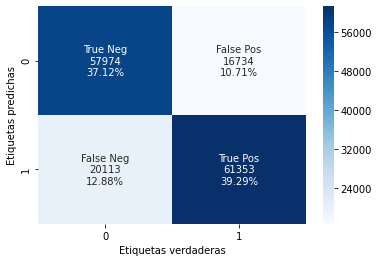

In [0]:
y = df_Log['is_canceled']
X = creador_X(df_Log, columnas_a_descartar)



# Instanciamos la clase SMOTE y realizamos el oversampling:

sm = SMOTE(random_state=12)

X, y = sm.fit_sample(X, y)

yLogOver = y


modeltouse = models['LogisticOver']

y_pred_logOver = modeltouse.predict(X)

#modeltouse.fit(X_train, y_train)
y_probs_logOver = modeltouse.predict_proba(X)

fpr_logOver,tpr_logOver,thr_logOver = roc_curve(y, y_probs_logOver[:,1])

metricas_resultados(y,y_pred_logOver)

### KNN Overfitted


      Accuracy ---------------> 0.584
      Recall/Sensitivity -----> 0.967
      Specificity ------------> 0.202
      Precision --------------> 0.548
      f1 score ---------------> 0.7


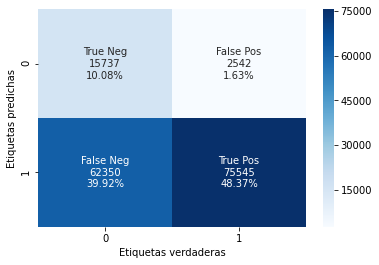

In [0]:
y = df_knn['is_canceled']
X = creador_X(df_knn, columnas_a_descartar)
yKNNOver = y




# Instanciamos la clase SMOTE y realizamos el oversampling:

sm = SMOTE(random_state=12)

X, y = sm.fit_sample(X, y)


modeltouse = models['KNNOver']

y_pred_KNNOver = modeltouse.predict(X)

#modeltouse.fit(X_train, y_train)
y_probs_KNNOver = modeltouse.predict_proba(X)

fpr_KNNOver,tpr_KNNOver,thr_KNNOver = roc_curve(y, y_probs_KNNOver[:,1])

metricas_resultados(y,y_pred_KNNOver)

### Logistic Balanced


      Accuracy ---------------> 0.794
      Recall/Sensitivity -----> 0.638
      Specificity ------------> 0.884
      Precision --------------> 0.761
      f1 score ---------------> 0.694


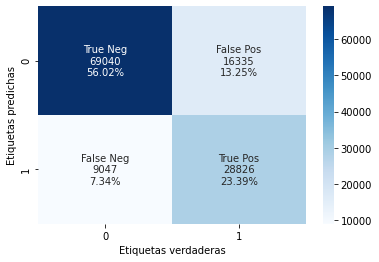

In [0]:
y = df_logB['is_canceled']
X = creador_X(df_logB, columnas_a_descartar)
yLogBal = y


modeltouse = models['LogisticBal']

y_pred_LogBal = modeltouse.predict(X)

#modeltouse.fit(X_train, y_train)
y_probs_LogBal = modeltouse.predict_proba(X)

fpr_LogBal,tpr_LogBal,thr_LogBal = roc_curve(y, y_probs_LogBal[:,1])

metricas_resultados(y,y_pred_LogBal)

## Random Forest Overfitted


      Accuracy ---------------> 0.685
      Recall/Sensitivity -----> 0.818
      Specificity ------------> 0.552
      Precision --------------> 0.646
      f1 score ---------------> 0.722


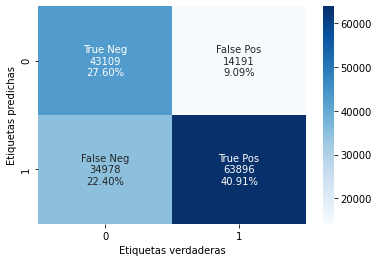

In [0]:
y = df_RF['is_canceled']
X = creador_X(df_to_model_RF, columnas_a_descartar)


# Instanciamos la clase SMOTE y realizamos el oversampling:

sm = SMOTE(random_state=12)

X, y = sm.fit_sample(X, y)

yRFOver = y

modeltouse = models['RandomForestOver']

y_pred_RFOver = modeltouse.predict(X)

#modeltouse.fit(X_train, y_train)
y_probs_RFOver = modeltouse.predict_proba(X)

fpr_RFOver,tpr_RFOver,thr_RFOver = roc_curve(y, y_probs_RFOver[:,1])

metricas_resultados(y,y_pred_RFOver)

## Comparacion de Curvas

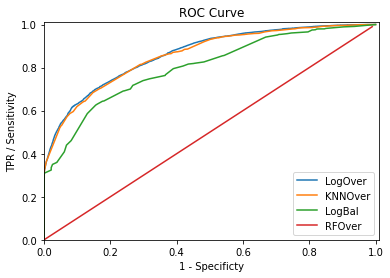

In [0]:
fpr_LogOver,tpr_LogOver,thr_LogOver = roc_curve(yLogOver, y_probs_logOver[:,1])
#fpr_KNNOver,tpr_KNNOver,thr_KNNOver = roc_curve(yKNNOver, y_probs_KNNOver[:,1])
fpr_LogBal,tpr_LogBal,thr_LogBal = roc_curve(yLogBal, y_probs_LogBal[:,1])
fpr_RFOver,tpr_RFOver,thr_RFOver = roc_curve(yRFOver, y_probs_RFOver[:,1])

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_LogOver,tpr_LogOver)
#plt.plot(fpr_KNNOver,tpr_KNNOver)
plt.plot(fpr_LogBal,tpr_LogBal)
plt.plot(fpr_RFOver,tpr_RFOver)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend(['LogOver',
            'KNNOver',
            'LogBal',
            'RFOver'])
plt.show() 

In [0]:
print('AUC-LogOver=', auc(fpr_LogOver, tpr_LogOver))
#print('AUC-KNNOver=', auc(fpr_KNNOver, tpr_KNNOver))
print('AUC-LogBal=', auc(fpr_LogBal, tpr_LogBal))
print('AUC-LogBal=', auc(fpr_LogBal, tpr_LogBal))

AUC-LogOver= 0.863400360573466
AUC-LogBal= 0.8584933450741621
AUC-LogBal= 0.8584933450741621


# Probar con o sin PCA en los 3 mejores modelos, reduccion de X %

In [0]:
# Solo modelar PCA con los modeladores antes usados

In [0]:
### Logistic Overfitted PCA 68 - 40

In [0]:
y = df_Log['is_canceled']
X = creador_X(df_Log, columnas_a_descartar)


# Separación entre train y test con funcion PCA
X_train, X_test, y_train, y_test = transformar_x_con_pca(X,y, 40)

# Instanciamos la clase SMOTE y realizamos el oversampling:

sm = SMOTE(random_state=12)

X_train, y_train = sm.fit_sample(X_train, y_train)

# definimos los modelos que vamos a usar
model = {'LogisticOverPCA': LogisticRegression(C=best_cLog)}

modelsPCA1, scalerPCA1, df_errorPCA1, errPCA1 = train_eval_models(model,X_train, y_train)

err_testPCA1 = test_models(modelsPCA1, scalerPCA1, X_test, y_test)

err = pd.concat([err,errPCA1])
err_test = pd.concat([err_test,err_testPCA1])



### KNN Overfitted PCA 80 - 60

In [0]:
y = df_knn['is_canceled']
X = creador_X(df_knn, columnas_a_descartar)


# Separación entre train y test con funcion PCA
X_train, X_test, y_train, y_test = transformar_x_con_pca(X,y, 60)

# Instanciamos la clase SMOTE y realizamos el oversampling:

sm = SMOTE(random_state=12)

X_train, y_train = sm.fit_sample(X_train, y_train)


# definimos los modelos que vamos a usar
model = {'KNNOverPCA': KNeighborsClassifier(n_neighbors=best_k)}

modelsPCA2, scalerPCA2, df_errorPCA2, errPCA2 = train_eval_models(model,X_train, y_train)

err_testPCA2 = test_models(modelsPCA2, scalerPCA2, X_test, y_test)

err = pd.concat([err,errPCA2])
err_test = pd.concat([err_test,err_testPCA2])

### Logistic Balanced PCA 20 - 15

In [0]:
y = df_logB['is_canceled']
X = creador_X(df_logB, columnas_a_descartar)


# Separación entre train y test con funcion PCA
X_train, X_test, y_train, y_test = transformar_x_con_pca(X,y, 10)

# definimos los modelos que vamos a usar
model = {'LogisticBalPCA': LogisticRegression(class_weight='balanced', C=best_cLogB)}

modelsPCA3, scalerPCA3, df_errorPCA3, errPCA3 = train_eval_models(model,X_train, y_train)

err_testPCA3 = test_models(modelsPCA3, scalerPCA3, X_test, y_test)

err = pd.concat([err,errPCA3])
err_test = pd.concat([err_test,err_testPCA3])



## Random Forest Overfitted PCA 19 - 13

In [0]:
y = df_RF['is_canceled']
X = creador_X(df_RF, columnas_a_descartar)


# Separación entre train y test con funcion PCA
X_train, X_test, y_train, y_test = transformar_x_con_pca(X,y,13)

# Instanciamos la clase SMOTE y realizamos el oversampling:

sm = SMOTE(random_state=12)

X_train, y_train = sm.fit_sample(X_train, y_train)


# definimos los modelos que vamos a usar
model = {'RandomForestOverPCA': RandomForestClassifier(n_estimators = best_nRFBal, class_weight = 'balanced')}

modelsPCA4, scalerPCA4, df_errorPCA4, errPCA4 = train_eval_models(model,X_train, y_train)

err_testPCA4 = test_models(modelsPCA4, scalerPCA4, X_test, y_test)

err = pd.concat([err,errPCA4])
err_test = pd.concat([err_test,err_testPCA4])


In [0]:
display(err, err_test)


,test_accuracy,test_f1,test_precision,test_recall
LogisticOver,0.77,0.77,0.78,0.76
NBOver,0.69,0.74,0.65,0.85
KNNOver,0.79,0.78,0.84,0.72
RandomForestOver,0.83,0.83,0.83,0.84
LogisticUnder,0.77,0.76,0.77,0.76
NBUnder,0.69,0.73,0.65,0.83
KNNUnder,0.74,0.69,0.85,0.59
RandomForestUnder,0.81,0.81,0.82,0.80
LogisticBal,0.79,0.70,0.73,0.68
RandomForestBal,0.81,0.81,0.82,0.80


,accuracy,f1,precision,recall,roc_auc
LogisticOver,0.78,0.72,0.68,0.76,0.78
NBOver,0.66,0.64,0.52,0.85,0.70
KNNOver,0.81,0.72,0.77,0.68,0.78
RandomForestOver,0.82,0.77,0.73,0.81,0.82
LogisticUnder,0.78,0.71,0.67,0.76,0.77
NBUnder,0.66,0.64,0.52,0.83,0.70
KNNUnder,0.78,0.66,0.77,0.58,0.74
RandomForestUnder,0.82,0.76,0.72,0.81,0.82
LogisticBal,0.80,0.72,0.75,0.69,0.78
RandomForestBal,0.82,0.77,0.73,0.82,0.82


In [0]:
err_testALL = err_test.sort_values(by=bestmodelelection)
err_testALL

,accuracy,f1,precision,recall,roc_auc
NBUnder,0.66,0.64,0.52,0.83,0.70
NBOver,0.66,0.64,0.52,0.85,0.70
LogisticBalPCA,0.74,0.65,0.63,0.67,0.72
LogisticOverPCA,0.73,0.66,0.62,0.70,0.73
KNNUnder,0.78,0.66,0.77,0.58,0.74
LogisticUnder,0.78,0.71,0.67,0.76,0.77
LogisticOver,0.78,0.72,0.68,0.76,0.78
KNNOver,0.81,0.72,0.77,0.68,0.78
LogisticBal,0.80,0.72,0.75,0.69,0.78
KNNOverPCA,0.80,0.73,0.72,0.74,0.79


In [0]:
models.update(modelsPCA1)
models.update(modelsPCA2)
models.update(modelsPCA3)
models.update(modelsPCA4)


# Graficar los modelos

### Logistic Overfitted PCA 68 - 40


      Accuracy ---------------> 0.701
      Recall/Sensitivity -----> 0.776
      Specificity ------------> 0.658
      Precision --------------> 0.568
      f1 score ---------------> 0.656


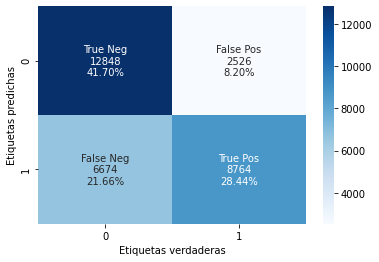

In [0]:
y = df_Log['is_canceled']
X = creador_X(df_Log, columnas_a_descartar)


# Separación entre train y test con funcion PCA
X_train, X_test, y_train, y_test = transformar_x_con_pca(X,y, 40)


# Instanciamos la clase SMOTE y realizamos el oversampling:

sm = SMOTE(random_state=12)

X_train, y_train = sm.fit_sample(X_train, y_train)

y_testLogOver = y_test


modeltouse = models['LogisticOverPCA']

y_pred_logOverPCA = modeltouse.predict(X_test)

#modeltouse.fit(X_train, y_train)
y_probs_logOverPCA = modeltouse.predict_proba(X_test)

fpr_logOverPCA,tpr_logOverPCA,thr_logOverPCA = roc_curve(y_test, y_probs_logOverPCA[:,1])

metricas_resultados(y_test,y_pred_logOverPCA)

### KNN Overfitted PCA 80 - 60


      Accuracy ---------------> 0.8
      Recall/Sensitivity -----> 0.731
      Specificity ------------> 0.84
      Precision --------------> 0.725
      f1 score ---------------> 0.728


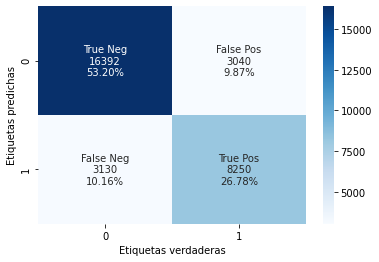

In [0]:
y = df_knn['is_canceled']
X = creador_X(df_knn, columnas_a_descartar)


# Separación entre train y test con funcion PCA
X_train, X_test, y_train, y_test = transformar_x_con_pca(X,y, 60)

y_testKNNOverPCA = y_test

# Instanciamos la clase SMOTE y realizamos el oversampling:

sm = SMOTE(random_state=12)

X_train, y_train = sm.fit_sample(X_train, y_train)

y_testKNNOver = y_train

modeltouse = models['KNNOverPCA']

y_pred_KNNOverPCA = modeltouse.predict(X_test)

#modeltouse.fit(X_train, y_train)
y_probs_KNNOverPCA = modeltouse.predict_proba(X_test)

fpr_KNNOverPCA,tpr_KNNOverPCA,thr_KNNOverPCA = roc_curve(y_test, y_probs_KNNOverPCA[:,1])

metricas_resultados(y_test,y_pred_KNNOverPCA)

### Logistic Balanced PCA



      Accuracy ---------------> 0.715
      Recall/Sensitivity -----> 0.68
      Specificity ------------> 0.735
      Precision --------------> 0.598
      f1 score ---------------> 0.636


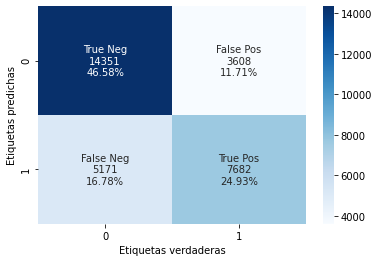

In [0]:
y = df_logB['is_canceled']
X = creador_X(df_logB, columnas_a_descartar)


# Separación entre train y test con funcion PCA
X_train, X_test, y_train, y_test = transformar_x_con_pca(X,y, 10)


modeltouse = models['LogisticBalPCA']

y_pred_LogBalPCA = modeltouse.predict(X_test)

#modeltouse.fit(X_train, y_train)
y_probs_LogBalPCA = modeltouse.predict_proba(X_test)

fpr_LogBalPCA,tpr_LogBalPCA,thr_LogBalPCA = roc_curve(y_test, y_probs_LogBalPCA[:,1])

metricas_resultados(y_test,y_pred_LogBalPCA)

## Forest Overfitted PCA


      Accuracy ---------------> 0.661
      Recall/Sensitivity -----> 0.365
      Specificity ------------> 0.832
      Precision --------------> 0.558
      f1 score ---------------> 0.441


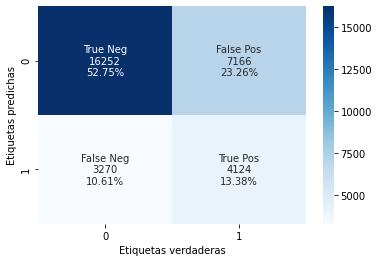

In [0]:
y = df_RFBal['is_canceled']
X = creador_X(df_RFBal, columnas_a_descartar)


# Separación entre train y test con funcion PCA
X_train, X_test, y_train, y_test = transformar_x_con_pca(X,y, 13)

# Instanciamos la clase SMOTE y realizamos el oversampling:

sm = SMOTE(random_state=12)

X_train, y_train = sm.fit_sample(X_train, y_train)

y_testRFOverPCA = y_test


modeltouse = models['RandomForestOverPCA']

y_pred_RFBalPCA = modeltouse.predict(X_test)

#modeltouse.fit(X_train, y_train)
y_probs_RFBalPCA = modeltouse.predict_proba(X_test)

fpr_RFBalPCA,tpr_RFBal,thr_RFBalPCA = roc_curve(y_test, y_probs_RFBalPCA[:,1])

metricas_resultados(y_test,y_pred_RFBalPCA)

## Comparacion de Curvas

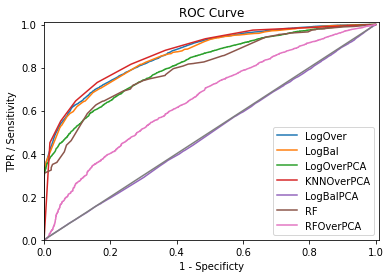

In [0]:

fpr_LogOverPCA,tpr_LogOverPCA,thr_LogOverPCA = roc_curve(y_testLogOver, y_probs_logOverPCA[:,1])
fpr_KNNOverPCA,tpr_KNNOverPCA,thr_KNNOverPCA = roc_curve(y_testKNNOverPCA, y_probs_KNNOverPCA[:,1])
fpr_LogBalPCA,tpr_LogBalPCA,thr_LogBalPCA = roc_curve(y_test, y_probs_LogBalPCA[:,1])
fpr_RFBalPCA,tpr_RFBalPCA,thr_RFBalPCA = roc_curve(y_testRFOverPCA, y_probs_RFBalPCA[:,1])

plt.axis([0, 1.01, 0, 1.01])
plt.xlabel('1 - Specificty')
plt.ylabel('TPR / Sensitivity')
plt.title('ROC Curve')
plt.plot(fpr_LogOver,tpr_LogOver)
#plt.plot(fpr_KNNOver,tpr_KNNOver)
plt.plot(fpr_LogBal,tpr_LogBal)
plt.plot(fpr_LogOverPCA,tpr_LogOverPCA)
plt.plot(fpr_KNNOverPCA,tpr_KNNOverPCA)
plt.plot(fpr_LogBalPCA,tpr_LogBalPCA)
plt.plot(fpr_RFOver,tpr_RFOver)
plt.plot(fpr_RFBalPCA,tpr_RFBalPCA)
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01))
plt.legend(['LogOver','LogBal', 'LogOverPCA','KNNOverPCA','LogBalPCA','RF','RFOverPCA'])
plt.show() 


In [0]:

print('AUC-LogOver=', auc(fpr_LogOver, tpr_LogOver))
#print('AUC-KNNOver=', auc(fpr_KNNOver, tpr_KNNOver))
print('AUC-LogBal=', auc(fpr_LogBal, tpr_LogBal))
print('AUC-LogOverPCA=', auc(fpr_LogOverPCA, tpr_LogOverPCA))
print('AUC-KNNOverPCA=', auc(fpr_KNNOverPCA, tpr_KNNOverPCA))
print('AUC-LogBalPCA=', auc(fpr_LogBalPCA, tpr_LogBalPCA))
print('AUC-RFOver=', auc(fpr_RFOver, tpr_RFOver))
print('AUC-RFOverPCA=', auc(fpr_RFBalPCA, tpr_RFBalPCA))
err_testALLPCA = err_test.sort_values(by=bestmodelelection)
display(err_testALLPCA)


AUC-LogOver= 0.863400360573466
AUC-LogBal= 0.8584933450741621
AUC-LogOverPCA= 0.8127243692905255
AUC-KNNOverPCA= 0.8702002891244227
AUC-LogBalPCA= 0.49478275015564643
AUC-RFOver= 0.8004594806460984
AUC-RFOverPCA= 0.6547303040452465


,accuracy,f1,precision,recall,roc_auc
NBUnder,0.66,0.64,0.52,0.83,0.70
NBOver,0.66,0.64,0.52,0.85,0.70
LogisticBalPCA,0.74,0.65,0.63,0.67,0.72
LogisticOverPCA,0.73,0.66,0.62,0.70,0.73
KNNUnder,0.78,0.66,0.77,0.58,0.74
LogisticUnder,0.78,0.71,0.67,0.76,0.77
LogisticOver,0.78,0.72,0.68,0.76,0.78
KNNOver,0.81,0.72,0.77,0.68,0.78
LogisticBal,0.80,0.72,0.75,0.69,0.78
KNNOverPCA,0.80,0.73,0.72,0.74,0.79


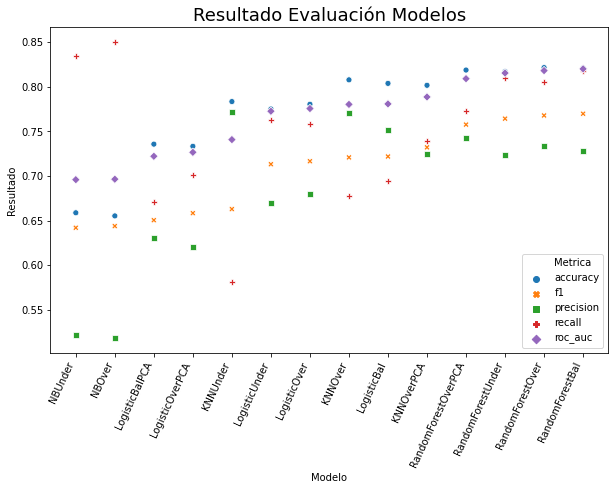

In [0]:
compararModelos = err_testALLPCA.T.unstack().reset_index()
compararModelos.columns = ["Modelo","Metrica","Resultado"]

fig = plt.figure(figsize=(10,6))
ax1 = sns.scatterplot(x=compararModelos["Modelo"], y=compararModelos["Resultado"],hue=compararModelos["Metrica"],style=compararModelos["Metrica"],data=compararModelos)
ax1.set_title('Resultado Evaluación Modelos', fontsize=18)
plt.xticks(rotation=65, horizontalalignment='right');

# Mejor modelo:

## Thresholds de acuerdo a la cat de avg d rate

In [0]:
y = df_RF['is_canceled']
X = creador_X(df_RF, columnas_a_descartar)

# Separación entre train y test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25, 
                                                    random_state=42)

model = RandomForestClassifier(n_estimators = best_nRF)

# Instanciamos la clase SMOTE y realizamos el oversampling:
sm = SMOTE(random_state=12)
X_train, y_train = sm.fit_sample(X_train, y_train)

model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=960)


      Accuracy ---------------> 0.822
      Recall/Sensitivity -----> 0.805
      Specificity ------------> 0.832
      Precision --------------> 0.734
      f1 score ---------------> 0.768


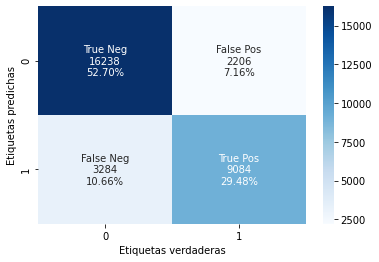

In [0]:
y_pred = model.predict(X_test)

y_predict_proba = model.predict_proba(X_test)

metricas_resultados(y_test,y_pred)

In [0]:
sample = 10000

In [0]:
df_RF['average_d_rate'] = df['average_d_rate']

df_to_check = df_RF.sample(sample)


columnas_a_descartar = ['is_canceled', 'average_d_rate']
X = creador_X(df_RF, columnas_a_descartar)
y_predict_proba = model.predict_proba(X)
df_to_check['y_pred'] = pd.DataFrame(model.predict(X))
df_to_check['1_chances'] = pd.DataFrame(y_predict_proba[:, 1])



In [0]:
def f(row, superhigh, high, med, low):
    if row['average_d_rate'] > 250:
        val = superhigh
    elif  row['average_d_rate'] > 104:
        val = high
    elif  row['average_d_rate']> 71:
        val = med
    elif  row['average_d_rate'] > 0:
        val = low
    else:
        val = 0.5
    return val






for a in [0.5,0.55, 0.45, 0.4, 0.6]:
    k = {}
    for b in [30, 20, 10]:
        superhigh = a+(b/130)
        high = a+(b/250)
        med = a
        low = a+(b/-400)
        df_to_check['avg_cat_to_select'] = df_to_check.apply(f,args=(superhigh, high, med, low), axis=1)
        
        df_to_check['cat_predict'] = np.where(df_to_check['1_chances']>df_to_check['avg_cat_to_select'], 1, 0)
        df_to_check['diff_with_modelpred'] = np.where(df_to_check['is_canceled']!=df_to_check['y_pred'], 1, 0)
        df_to_check['diff_with_catpred'] = np.where(df_to_check['is_canceled']!=df_to_check['cat_predict'], 1, 0)
        print("Values : SuperHigh: {} High: {} Med: {} Low: {}".format(superhigh, high, med, low))
        print('Model vs real: {}'.format(int(df_to_check.loc[df_to_check['diff_with_modelpred']==0,'diff_with_modelpred'].count())))
        print('Cat vs real: {}'.format(int(df_to_check.loc[df_to_check['diff_with_catpred']==0,'diff_with_catpred'].count())))
        print('Difference: {}'.format(int(df_to_check.loc[df_to_check['diff_with_modelpred']==0,'diff_with_modelpred'].count())-
                                     int(df_to_check.loc[df_to_check['diff_with_catpred']==0,'diff_with_catpred'].count())))
        print('/n')
                    
                                      

Values : SuperHigh: 0.7307692307692308 High: 0.62 Med: 0.5 Low: 0.425
Model vs real: 8590
Cat vs real: 8551
Difference: 39
/n
Values : SuperHigh: 0.6538461538461539 High: 0.58 Med: 0.5 Low: 0.45
Model vs real: 8590
Cat vs real: 8570
Difference: 20
/n
Values : SuperHigh: 0.5769230769230769 High: 0.54 Med: 0.5 Low: 0.475
Model vs real: 8590
Cat vs real: 8597
Difference: -7
/n
Values : SuperHigh: 0.7807692307692309 High: 0.67 Med: 0.55 Low: 0.47500000000000003
Model vs real: 8590
Cat vs real: 8588
Difference: 2
/n
Values : SuperHigh: 0.7038461538461539 High: 0.63 Med: 0.55 Low: 0.5
Model vs real: 8590
Cat vs real: 8620
Difference: -30
/n
Values : SuperHigh: 0.6269230769230769 High: 0.5900000000000001 Med: 0.55 Low: 0.525
Model vs real: 8590
Cat vs real: 8626
Difference: -36
/n
Values : SuperHigh: 0.6807692307692308 High: 0.5700000000000001 Med: 0.45 Low: 0.375
Model vs real: 8590
Cat vs real: 8480
Difference: 110
/n
Values : SuperHigh: 0.6038461538461539 High: 0.53 Med: 0.45 Low: 0.4
Mode

### Sample y prediccion

In [0]:

def f(row):
    if row['average_d_rate'] > 250:
        val = 0.67
    elif  row['average_d_rate'] > 104:
        val = 0.64
    elif  row['average_d_rate']> 71:
        val = 0.6
    elif  row['average_d_rate'] > 0:
        val = 0.575
    else:
        val = 0.5
    return val




df_to_check['avg_cat_to_select'] = df_to_check.apply(f, axis=1)

df_to_check['cat_predict'] = np.where(df_to_check['1_chances']>df_to_check['avg_cat_to_select'], 1, 0)
df_to_check['diff_with_modelpred'] = np.where(df_to_check['is_canceled']!=df_to_check['y_pred'], 1, 0)
df_to_check['diff_with_catpred'] = np.where(df_to_check['is_canceled']!=df_to_check['cat_predict'], 1, 0)
    

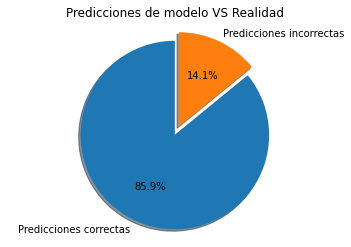

In [0]:


# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Predicciones correctas', 'Predicciones incorrectas'
sizes = df_to_check['diff_with_modelpred'].value_counts()
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')


fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set(aspect="equal", title=('Predicciones de modelo VS Realidad'))
#plt.title=('hola')


plt.show()

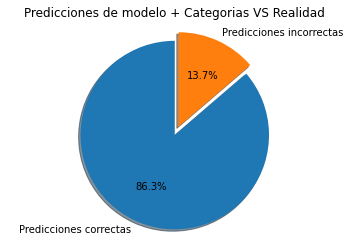

In [0]:
proptype = 'apartment'

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Predicciones correctas', 'Predicciones incorrectas'
sizes = df_to_check['diff_with_catpred'].value_counts()
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')


fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set(aspect="equal", title=('Predicciones de modelo + Categorias VS Realidad'))
#plt.title=('hola')


plt.show()

In [0]:
df_to_check['diff_with_modelpred'].value_counts()

0    8590
1    1410
Name: diff_with_modelpred, dtype: int64

In [0]:
df_to_check['diff_with_catpred'].value_counts()

0    8629
1    1371
Name: diff_with_catpred, dtype: int64

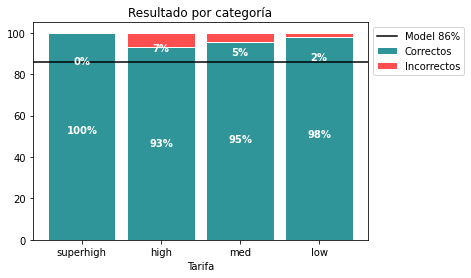

In [0]:
dfbarplot = df_to_check.groupby('avg_cat_to_select')['diff_with_catpred'].sum().reset_index()
dfbarplot["Correct"] = sample - dfbarplot['diff_with_catpred']
dfbarplot = dfbarplot.sort_values("avg_cat_to_select", ascending=False)
modelper = 100 - (df_to_check['diff_with_modelpred'].sum()/sample)*100

 
# From raw value to percentage
totals = [i+j for i,j in zip(dfbarplot["Correct"], dfbarplot["diff_with_catpred"])]
greenBars = [i / j * 100 for i,j in zip(dfbarplot["Correct"], totals)]
blueBars = [i / j * 100 for i,j in zip(dfbarplot["diff_with_catpred"], totals)]


def etiquetas(indice,dato, rotate, disty):                    
    for x,y in zip(indice, dato):
        label = "{0:.0%}".format(y/100)
        plt.annotate(label, 
                 (x,y),
                 rotation = rotate,
                     weight='bold',
                     color='white',
                 textcoords="offset points", 
                 xytext=(0,disty), 
                 ha='center') 

# plot
barWidth = 0.85
names = ["superhigh","high","med","low"]  
r = list(np.arange(0,len(dfbarplot['avg_cat_to_select'])))
# Create green Bars
plt.bar(r, greenBars, color='#2F9599', edgecolor='white', width=barWidth, label="Correctos")

etiquetas(r, greenBars, 0, -100)
# Create blue Bars
plt.bar(r, blueBars, bottom=[i for i in greenBars], color='#FF4E50', edgecolor='white', width=barWidth, label="Incorrectos")
etiquetas(r, blueBars, 0, 175)

plt.axhline(y=modelper, color='k', label="Model "+"{:.0%}".format(modelper/100))

# Custom x axis
plt.xticks(r, names)
plt.xlabel("Tarifa")
 
# Add a legend
plt.legend(loc='bottom right', bbox_to_anchor=(1,1), ncol=1)

plt.title("Resultado por categoría")
 
# Show graphic
plt.show()

## Conclusion

###### Luego de aplicar los conocimientos obtenidos logramos modificar el dataset, sus features y adaptar los modelos de clasificación de manera tal que pudimos obtener un porcentaje de resultados correctos del 86% utilizando un dataset reducido de 10k valores, de los cuales solo 560 casos dieron falsos positivos (5,6%).

Según nuestras estimaciones los hoteles cuentan con 150 reservas por día. Si normalmente el 38% se cancelan, con nuestro modelo podemos sobrevender el 27% de las reservas (41 reservas)
